
Rastrigin: 2D


In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 15.9 MB/s 
     |████████████████████████████████| 872 kB 53.2 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=50b383a902a25af29b35b5817656048a97d454c4feb321d6717a22e988ee40af
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=e1c4f3f0f08a489b5f27283cc6dfaa292421dd59b99e5caf45a98f53a4d4fed6
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [2]:
### 1. Import python modules/packages required:

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import warnings
import itertools
import seaborn as sns
import time

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential
from joblib import Parallel, delayed
from scipy.linalg import inv
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm, t
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Rastrigin'
n_test = 500
eps = 1e-08

util_gp = 'CBM_gp'
util_stp = 'CBM_stp'

n_init = 5 # random initialisations
iters = 20
opt = True

df = 3

In [4]:
### Objective Function - Rastrigin(x) 2-D:

def objfunc(x1_training, x2_training):
        return  operator * (10 * dim + x1_training** 2 - 10 * np.cos(2 * np.pi * x1_training)
                                    + x2_training** 2 - 10 * np.cos(2 * np.pi * x2_training)
                          )
            
# Constraints:
lb = -5.12 
ub = +5.12
    
# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}

# True y bounds:
operator = -1
y_global_orig = 0 # targets global minimum

# Test data:
x1_test = np.linspace(lb, ub, n_test) 
x2_test = np.linspace(lb, ub, n_test)
  
x_test = np.column_stack((x1_test,x2_test))

In [5]:
n_start_AcqFunc = iters
inverse = -1


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds   

class dtStudentProcess(tStudentProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the STP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        
        smd_adj = (self.nu + self.beta1 - 2) / (self.nu + self.n1 - 2)

        alpha = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), self.y)
        alpha_Kstar = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)      
        
        dm = np.dot(dKstar, alpha)
        ds = -2 * smd_adj * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds 
        

In [8]:
### Add exact acquisition function gradient as attribute:

Beta_CBM = dim

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBM_stp': self.CBM_stp,
            'CBM_gp': self.CBM_gp,
        }

        self.f = mode_dict[mode]
    
    def CBM_stp(self, y_global_orig, mean, std, ds, dm, nu=3.0):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - y_global_orig) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * dmdx
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval_stp(self, tau, mean, std, ds, dm, nu=3.0):
    
        return self.f(tau, mean, std, ds, dm, nu=3.0, **self.params)

    def CBM_gp(self, tau, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - y_global_orig) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * dmdx
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval_gp(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## dGPGO - Gaussian:

class dGPGO_gp(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact CBM: StdDev. x \t Approx CBM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_gp(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_gp(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_gp = np.empty((n_start, len(self.parameter_key)))
        f_best_gp = np.empty((n_start,))
        opt_gp = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_gp = np.array([res.x for res in opt_gp])
        f_best_gp = np.array([np.atleast_1d(res.fun)[0] for res in opt_gp])
        f_best_min_gp = min(f_best_gp)

        self.x_best_gp = x_best_gp
        self.f_best_gp = f_best_gp
        self.f_best_min_gp = f_best_min_gp
        self.x_best_std_gp = np.std(x_best_gp)
        self.best_gp = x_best_gp[np.argmin(f_best_gp)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_gp)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_gp = str(self.f_best_min_gp)
        x_best_std = str(self.x_best_std)
        x_best_std_gp = str(self.x_best_std_gp)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_gp = BOLD + OKGREEN + x_best_std_gp + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_gp))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO - Student's-t:

class dGPGO_stp(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact CBM: StdDev. x \t Approx CBM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_gp = np.empty((n_start, len(self.parameter_key)))
        f_best_gp = np.empty((n_start,))
        opt_gp = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_gp = np.array([res.x for res in opt_gp])
        f_best_gp = np.array([np.atleast_1d(res.fun)[0] for res in opt_gp])
        f_best_min_gp = min(f_best_gp)

        self.x_best_gp = x_best_gp
        self.f_best_gp = f_best_gp
        self.f_best_min_gp = f_best_min_gp
        self.x_best_std_gp = np.std(x_best_gp)
        self.best_gp = x_best_gp[np.argmin(f_best_gp)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_gp)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_gp = str(self.f_best_min_gp)
        x_best_std = str(self.x_best_std)
        x_best_std_gp = str(self.x_best_std_gp)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_gp = BOLD + OKGREEN + x_best_std_gp + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_gp))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_gp = time.time()
start_gp


1663684561.520381

In [13]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_1)
surrogate_gp_1 = dGaussianProcess(cov_func, optimize=opt)

gp_1 = dGPGO_gp(surrogate_gp_1, Acquisition_grad(util_gp), objfunc, param)
gp_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.84969467  2.25612281]	 20.33436270766351	 19.908403246996286	    	    
init	 [-5.1188288  -2.02411446]	 33.07414982069084	 19.908403246996286	    	    
init	 [-3.61721968 -4.17445279]	 53.347974723929894	 19.908403246996286	    	    
init	 [-3.21269544 -1.58145816]	 39.218472310354045	 19.908403246996286	    	    
init	 [-1.05710106  0.39748336]	 19.908403246996286	 19.908403246996286	    	    
1  	 [ 4.04077223 -4.24914728]	 44.655863836006326	 19.908403246996286	 3.9761379307136067	 4.416824073979648
2  	 [5.12 5.12]	 57.849427451571785	 19.908403246996286	 3.577999403585383	 3.686554539862921
3  	 [4.33434648 0.43303025]	 53.15679480591048	 19.908403246996286	 3.5801611974465017	 4.404941905396807
4  	 [-5.12        4.36680096]	 64.69123843795754	 19.908403246996286	 3.606156701197781	 4.335151062963049
5  	 [ 0.15863144 -5.09509868]	 32.28720315238102	 19.9084

In [14]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_2)
surrogate_gp_2 = dGaussianProcess(cov_func, optimize=opt)

gp_2 = dGPGO_gp(surrogate_gp_2, Acquisition_grad(util_gp), objfunc, param)
gp_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.6554122  -4.85451539]	 43.490296251903594	 18.964539418712707	    	    
init	 [ 0.50854377 -0.6622987 ]	 35.91861667536101	 18.964539418712707	    	    
init	 [-0.81543371 -1.73737143]	 20.479562046739524	 18.964539418712707	    	    
init	 [-3.02439799  1.2213347 ]	 18.964539418712707	 18.964539418712707	    	    
init	 [-2.05153614 -2.3876887 ]	 28.041315668371354	 18.964539418712707	    	    
1  	 [5.12       3.80666627]	 49.929724456015066	 18.964539418712707	 4.1050546592081405	 4.484021420452111
2  	 [ 4.8426374  -3.96513962]	 43.91494982239877	 18.964539418712707	 3.563388233680121	 4.370894969251236
3  	 [0.07190387 5.12      ]	 29.933192790802167	 18.964539418712707	 3.8155131633864685	 4.079687546206902
4  	 [-5.12 -5.12]	 57.849427451571785	 18.964539418712707	 3.7693301569602307	 4.143884537345106
5  	 [ 4.59895346 -0.06119922]	 40.013000057276244	 18.

In [15]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_3)
surrogate_gp_3 = dGaussianProcess(cov_func, optimize=opt)

gp_3 = dGPGO_gp(surrogate_gp_3, Acquisition_grad(util_gp), objfunc, param)
gp_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.52017052 2.1314337 ]	 27.953858411008774	 10.607662635789808	    	    
init	 [-2.14113547  0.11087468]	 10.607662635789808	 10.607662635789808	    	    
init	 [4.02377681 4.05804123]	 33.42749829480097	 10.607662635789808	    	    
init	 [-3.83400642 -2.99783293]	 28.650953928965198	 10.607662635789808	    	    
init	 [-4.59297584 -0.6061072 ]	 57.6631355589384	 10.607662635789808	    	    
1  	 [ 1.67759371 -3.17566691]	 32.790754957541495	 10.607662635789808	 2.6573005929159668	 3.8554081240475573
2  	 [-3.55868365  4.82551621]	 60.70894900147689	 10.607662635789808	 3.745474785896036	 4.330989448576486
3  	 [ 5.12       -0.35054927]	 44.95333655067316	 10.607662635789808	 3.2942345221416938	 3.54837426908336
4  	 [-1.57261072 -5.10194768]	 49.46255273895392	 10.607662635789808	 3.742843317094406	 3.4026926478457877
5  	 [ 4.60149323 -3.45085773]	 70.643906911060

In [16]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_4)
surrogate_gp_4 = dGaussianProcess(cov_func, optimize=opt)

gp_4= dGPGO_gp(surrogate_gp_4, Acquisition_grad(util_gp), objfunc, param)
gp_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [4.78238555 0.48365823]	 51.03163809010808	 14.323038259018315	    	    
init	 [4.84028785 2.19971578]	 39.78645699016559	 14.323038259018315	    	    
init	 [ 2.02474316 -2.90724357]	 14.323038259018315	 14.323038259018315	    	    
init	 [ 4.87705042 -5.05620219]	 52.80627247106233	 14.323038259018315	    	    
init	 [-2.52946061 -0.66773471]	 41.61497868486559	 14.323038259018315	    	    
1  	 [-2.37593933  5.12      ]	 51.68247899543054	 14.323038259018315	 3.4046308044637925	 4.1040976529906095
2  	 [-5.12 -5.12]	 57.849427451571785	 14.323038259018315	 4.016142298272456	 3.3440209650057
3  	 [1.96075032 5.12      ]	 33.07180734617556	 14.323038259018315	 3.401524308508833	 3.478886341742561
4  	 [0.79127683 1.31343873]	 23.667976899638028	 14.323038259018315	 3.3448081931247935	 3.4408481647183593
5  	 [-1.11005166 -4.9156598 ]	 29.06441368630989	 14.3230382590

In [17]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_5)
surrogate_gp_5 = dGaussianProcess(cov_func, optimize=opt)

gp_5 = dGPGO_gp(surrogate_gp_5, Acquisition_grad(util_gp), objfunc, param)
gp_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.84678993  3.79629882]	 33.93442008827236	 7.8108627039749745	    	    
init	 [-3.00319585  4.2865757 ]	 39.673876075575784	 7.8108627039749745	    	    
init	 [-0.11866943  1.14425716]	 7.8108627039749745	 7.8108627039749745	    	    
init	 [2.72289645 0.1886002 ]	 25.38160395721669	 7.8108627039749745	    	    
init	 [-2.08076286 -3.19773462]	 22.589982116319675	 7.8108627039749745	    	    
1  	 [ 4.32894502 -5.09733749]	 61.29459455724814	 7.8108627039749745	 4.55242772226513	 4.710018824156584
2  	 [5.12 5.12]	 57.849427451571785	 7.8108627039749745	 4.3969262420845885	 3.9310366096136073
3  	 [-5.12       -0.31196307]	 42.81767920097346	 7.8108627039749745	 3.5058108916311923	 3.8198609736323177
4  	 [1.09365057 4.84529954]	 30.718444110329266	 7.8108627039749745	 3.5569372879113366	 3.462156188475081
5  	 [-5.12 -5.12]	 57.849427451571785	 7.8108627039749745

In [18]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_6)
surrogate_gp_6 = dGaussianProcess(cov_func, optimize=opt)

gp_6 = dGPGO_gp(surrogate_gp_6, Acquisition_grad(util_gp), objfunc, param)
gp_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 4.02288795 -1.72052679]	 31.08835710146886	 17.28954482757088	    	    
init	 [ 3.28938622 -4.69302655]	 58.797867722203385	 17.28954482757088	    	    
init	 [-4.0175956   0.97333314]	 17.28954482757088	 17.28954482757088	    	    
init	 [ 0.30532979 -0.83141193]	 19.296253155889353	 17.28954482757088	    	    
init	 [-1.68542362  1.25459899]	 28.650630936276173	 17.28954482757088	    	    
1  	 [5.12 5.12]	 57.849427451571785	 17.28954482757088	 4.489952463590457	 4.414035674139899
2  	 [-5.12 -5.12]	 57.849427451571785	 17.28954482757088	 3.97984536510217	 4.251906732612083
3  	 [0.39214451 5.12      ]	 46.868810157297816	 17.28954482757088	 3.201753124879333	 3.7077524359619707
4  	 [-0.95411945 -4.92162186]	 26.733647602855974	 17.28954482757088	 3.129041652237295	 4.290556652802155
5  	 [3.88133086 1.66848017]	 35.40288027915065	 17.28954482757088	 2.563022914

In [19]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_7)
surrogate_gp_7 = dGaussianProcess(cov_func, optimize=opt)

gp_7 = dGPGO_gp(surrogate_gp_7, Acquisition_grad(util_gp), objfunc, param)
gp_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-4.33860312  2.86636843]	 45.646133072936244	 22.52235437888213	    	    
init	 [-0.63068947  2.28828342]	 34.83012662845338	 22.52235437888213	    	    
init	 [4.8946126  0.39419771]	 44.09657005662876	 22.52235437888213	    	    
init	 [ 0.01147355 -4.38219639]	 36.613209822404315	 22.52235437888213	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 22.52235437888213	 22.52235437888213	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 22.52235437888213	 3.8025131145856026	 3.851273964329224
2  	 [3.61253123 5.12      ]	 59.57788081906507	 22.52235437888213	 3.8663027613624097	 4.1156129375154995
3  	 [ 4.52828366 -4.16265171]	 62.45867448569435	 22.52235437888213	 3.634840892211503	 3.9789257893234784
4  	 [-4.02558214 -1.33646422]	 33.289738493146906	 22.52235437888213	 2.8824208447363557	 3.046307140328312
5	 [ 1.30561208 -0.85934449]	 19.524183305217868	 19.5241

In [20]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_8)
surrogate_gp_8 = dGaussianProcess(cov_func, optimize=opt)

gp_8 = dGPGO_gp(surrogate_gp_8, Acquisition_grad(util_gp), objfunc, param)
gp_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [3.82391708 4.79785639]	 50.20079446939181	 13.871821018360485	    	    
init	 [3.78055209 0.31596228]	 36.5114251593508	 13.871821018360485	    	    
init	 [-2.73686192 -5.00327624]	 43.34985765011677	 13.871821018360485	    	    
init	 [-0.7119993  -0.99992207]	 13.871821018360485	 13.871821018360485	    	    
init	 [ 0.23218863 -0.22126801]	 17.190590355445654	 13.871821018360485	    	    
1  	 [ 4.96376909 -4.82584897]	 53.59844872911706	 13.871821018360485	 3.387052777709809	 4.193993050097452
2  	 [-5.03492225  2.95509263]	 34.71822332027364	 13.871821018360485	 3.662941386098847	 3.857809492862984
3  	 [-0.88346808  5.12      ]	 32.26811868389334	 13.871821018360485	 3.3523358048630514	 3.691496624506882
4  	 [ 1.08441164 -4.79070842]	 32.97066919816801	 13.871821018360485	 3.622607016460717	 3.3469253363783227
5  	 [-5.12       -1.44672511]	 50.46269798040832	

In [21]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_9)
surrogate_gp_9 = dGaussianProcess(cov_func, optimize=opt)

gp_9 = dGPGO_gp(surrogate_gp_9, Acquisition_grad(util_gp), objfunc, param)
gp_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-5.01376866  0.01919582]	 25.248289026162446	 24.454800313488693	    	    
init	 [-0.04328148 -3.74958562]	 24.454800313488693	 24.454800313488693	    	    
init	 [-3.66478248 -2.88195916]	 39.46509426509438	 24.454800313488693	    	    
init	 [-0.83447623 -2.57944404]	 31.06766397812992	 24.454800313488693	    	    
init	 [-4.25922917 -1.58209393]	 49.922543556206975	 24.454800313488693	    	    
1  	 [5.12 5.12]	 57.849427451571785	 24.454800313488693	 3.043380568355621	 3.316977016880765
2  	 [ 5.03510189 -1.04871218]	 27.159021207695012	 24.454800313488693	 3.3424074547097242	 3.648479045892864
3  	 [-1.47691515  4.45110802]	 61.42048086129838	 24.454800313488693	 2.9704173404353327	 3.136174219647723
4  	 [1.55205862 1.27512773]	 35.07690748443045	 24.454800313488693	 3.235188472080086	 3.7083486360496583
5  	 [-2.25500396  1.29080468]	 29.6014135285589	 24.4548

In [22]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_10)
surrogate_gp_10 = dGaussianProcess(cov_func, optimize=opt)

gp_10 = dGPGO_gp(surrogate_gp_10, Acquisition_grad(util_gp), objfunc, param)
gp_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.77832339 -4.90750004]	 41.674330194390116	 13.839458310244165	    	    
init	 [1.36855793 2.54775176]	 44.69639719065837	 13.839458310244165	    	    
init	 [-0.01528819 -2.81808235]	 13.839458310244165	 13.839458310244165	    	    
init	 [-3.09183626  2.66783449]	 33.23221510904937	 13.839458310244165	    	    
init	 [-3.38830503 -4.2154003 ]	 54.73014366983691	 13.839458310244165	    	    
1  	 [ 5.12       -0.53830131]	 48.92630453431062	 13.839458310244165	 3.9623328748725384	 4.220880397495866
2  	 [5.12 5.12]	 57.849427451571785	 13.839458310244165	 3.591835018880886	 3.342362403186491
3  	 [-4.22754304 -0.73799187]	 37.76419470121735	 13.839458310244165	 3.1484816452112594	 3.5304409468150397
4  	 [ 1.68412295 -0.64902863]	 33.20662042356246	 13.839458310244165	 3.942434749474336	 3.8858240512849984
5  	 [-4.5050859   5.00650982]	 65.36419794062027	 13.8394

In [23]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_11)
surrogate_gp_11 = dGaussianProcess(cov_func, optimize=opt)

gp_11 = dGPGO_gp(surrogate_gp_11, Acquisition_grad(util_gp), objfunc, param)
gp_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.27403839 -4.92057353]	 47.655641290890955	 10.679755252484755	    	    
init	 [-0.37664229  2.30332343]	 35.87889240695259	 10.679755252484755	    	    
init	 [-0.81711509 -0.14922651]	 10.679755252484755	 10.679755252484755	    	    
init	 [-4.98912446 -0.12931474]	 28.05462905574235	 10.679755252484755	    	    
init	 [4.52410012 3.59214172]	 71.62694632141611	 10.679755252484755	    	    
1  	 [ 3.03550212 -4.46785095]	 49.22040431745476	 10.679755252484755	 3.176352698044778	 4.315383283922617
2  	 [ 4.25317778 -0.5528745 ]	 48.04804943316525	 10.679755252484755	 2.9798530680580884	 3.85572408467639
3  	 [-1.00991277  5.12      ]	 29.964027603604436	 10.679755252484755	 3.9922916574731695	 4.422224481082061
4  	 [-0.1498688  -3.28114456]	 26.84825537579198	 10.679755252484755	 2.9987181170538557	 3.271768252831769
5  	 [-3.75485684  2.90206029]	 34.05020715463

In [24]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_12)
surrogate_gp_12 = dGaussianProcess(cov_func, optimize=opt)

gp_12 = dGPGO_gp(surrogate_gp_12, Acquisition_grad(util_gp), objfunc, param)
gp_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.54137249  2.45810889]	 57.903242869085595	 40.51116653209555	    	    
init	 [-2.42365424  0.34549139]	 40.51116653209555	 40.51116653209555	    	    
init	 [-4.97075238  4.28796936]	 55.62655915398208	 40.51116653209555	    	    
init	 [ 4.10332011 -4.77776458]	 49.962803461970296	 40.51116653209555	    	    
init	 [ 4.6791612  -3.71497655]	 62.183891474990624	 40.51116653209555	    	    
1  	 [5.12 5.12]	 57.849427451571785	 40.51116653209555	 3.997567604985732	 4.0801075110967275
2  	 [-5.12 -5.12]	 57.849427451571785	 40.51116653209555	 3.7284175150110275	 3.512780681811885
3	 [2.39120848 0.97308089]	 24.5607718679666	 24.5607718679666	 2.867693465177461	 3.038611278592502
4  	 [-0.46882217 -4.42580229]	 58.549093844089114	 24.5607718679666	 2.9831149742826653	 3.3444712592331722
5  	 [0.8912866  4.54090272]	 43.32935056682179	 24.5607718679666	 2.561024087097

In [25]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_13)
surrogate_gp_13 = dGaussianProcess(cov_func, optimize=opt)

gp_13 = dGPGO_gp(surrogate_gp_13, Acquisition_grad(util_gp), objfunc, param)
gp_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.84367268 -2.68757791]	 33.58019830007169	 17.435826639425656	    	    
init	 [3.32061217 4.76927179]	 56.857057997503354	 17.435826639425656	    	    
init	 [ 4.83943541 -0.47667971]	 48.211919361679726	 17.435826639425656	    	    
init	 [1.11659482 2.82139151]	 17.435826639425656	 17.435826639425656	    	    
init	 [1.45012065 2.27346667]	 38.25352329493884	 17.435826639425656	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 17.435826639425656	 3.470515195135488	 3.4849224408722663
2  	 [-4.47999318  1.98768914]	 43.97224166814816	 17.435826639425656	 2.8789926578946674	 3.862546434992129
3  	 [-2.01246334 -1.58988022]	 25.055683649968632	 17.435826639425656	 3.182925962914232	 3.3450558782858715
4  	 [-1.67907248  5.12      ]	 46.05444967932614	 17.435826639425656	 3.4186773106016104	 3.726364274536521
5  	 [-0.44791267 -5.12      ]	 48.594560086629784	 17.435

In [26]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_14)
surrogate_gp_14 = dGaussianProcess(cov_func, optimize=opt)

gp_14 = dGPGO_gp(surrogate_gp_14, Acquisition_grad(util_gp), objfunc, param)
gp_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.14277984 2.79721013]	 18.683085263052178	 10.423838604848608	    	    
init	 [ 3.7931795  -5.03759925]	 47.36348784446708	 10.423838604848608	    	    
init	 [-1.94830412  4.68586229]	 40.19779334078636	 10.423838604848608	    	    
init	 [ 0.13431513 -1.86076749]	 10.423838604848608	 10.423838604848608	    	    
init	 [ 0.40140736 -2.85434939]	 30.353548735049138	 10.423838604848608	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 10.423838604848608	 4.455638515783688	 4.024080613518249
2  	 [5.12 5.12]	 57.849427451571785	 10.423838604848608	 3.9746175702667017	 3.989923881132954
3  	 [-4.95963274  0.24438011]	 34.62457675915518	 10.423838604848608	 2.875533328151242	 3.721414629218412
4  	 [4.80689117 0.02990701]	 29.784193462556928	 10.423838604848608	 2.9877084558850124	 3.600702569365357
5  	 [-1.5569349  0.0137885]	 21.82867351124596	 10.423838604848608	 2.

In [27]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_15)
surrogate_gp_15 = dGaussianProcess(cov_func, optimize=opt)

gp_15 = dGPGO_gp(surrogate_gp_15, Acquisition_grad(util_gp), objfunc, param)
gp_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 3.57189322 -3.28810573]	 54.938487770767075	 7.990765314336182	    	    
init	 [-4.56332069 -1.41784631]	 60.750198753157726	 7.990765314336182	    	    
init	 [-2.29989449  0.3072023 ]	 31.984997246800887	 7.990765314336182	    	    
init	 [-1.9873903  -2.00218256]	 7.990765314336182	 7.990765314336182	    	    
init	 [-3.97576933 -2.5610341 ]	 41.754957769694336	 7.990765314336182	    	    
1  	 [5.12 5.12]	 57.849427451571785	 7.990765314336182	 3.81309744870819	 3.988805034976028
2  	 [-0.3517064  5.12     ]	 45.012664103899695	 7.990765314336182	 2.5904252535457424	 3.8430137896456533
3  	 [2.59308743 1.16950208]	 31.584661731004793	 7.990765314336182	 3.402567156577174	 3.655499811133456
4  	 [-5.06640777  4.03179879]	 42.980762793572524	 7.990765314336182	 3.2622413250523357	 4.03712405988526
5  	 [-1.61688397 -5.12      ]	 48.96133288911461	 7.99076531433618

In [28]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_16)
surrogate_gp_16 = dGaussianProcess(cov_func, optimize=opt)

gp_16 = dGPGO_gp(surrogate_gp_16, Acquisition_grad(util_gp), objfunc, param)
gp_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.83349935  0.23719262]	 22.27210456874814	 22.27210456874814	    	    
init	 [ 0.51918292 -4.65303603]	 57.57021076017139	 22.27210456874814	    	    
init	 [-1.42613673 -2.83565116]	 33.89145899403749	 22.27210456874814	    	    
init	 [ 1.9325559  -3.44339021]	 35.85029586225333	 22.27210456874814	    	    
init	 [-4.39987336  4.51595121]	 77.78800881964571	 22.27210456874814	    	    
1  	 [5.12 5.12]	 57.849427451571785	 22.27210456874814	 3.9731757856614807	 4.088893153423972
2  	 [5.12       0.13572283]	 32.364151347148145	 22.27210456874814	 3.7448522637760786	 3.5179007492166434
3  	 [0.43755246 3.98750252]	 35.36249901006297	 22.27210456874814	 3.430504908953448	 4.087158799975003
4  	 [-5.12 -5.12]	 57.849427451571785	 22.27210456874814	 3.579304558473055	 3.6555954394817247
5  	 [0.82510209 0.43263036]	 25.439743547492817	 22.27210456874814	 2.3219441063

In [29]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_17)
surrogate_gp_17 = dGaussianProcess(cov_func, optimize=opt)

gp_17 = dGPGO_gp(surrogate_gp_17, Acquisition_grad(util_gp), objfunc, param)
gp_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.10263037  0.31320838]	 20.395145364684023	 20.395145364684023	    	    
init	 [-3.15882714 -4.42470033]	 53.03732051200137	 20.395145364684023	    	    
init	 [2.93873111 1.60085526]	 29.989224812583537	 20.395145364684023	    	    
init	 [1.40821398 0.77417363]	 29.451989415882437	 20.395145364684023	    	    
init	 [-4.71999574 -1.45598869]	 55.89242173757483	 20.395145364684023	    	    
1  	 [ 4.96008736 -4.44720822]	 64.14783177084814	 20.395145364684023	 3.6883753167172184	 4.813589322179726
2  	 [-1.51638506  5.12      ]	 51.17119027079279	 20.395145364684023	 3.92302113931978	 3.788847483934455
3  	 [5.12 5.12]	 57.849427451571785	 20.395145364684023	 3.576133682979501	 3.6435871025893705
4  	 [ 0.77481686 -3.17286901]	 24.455665433265764	 20.395145364684023	 3.6299817384343878	 3.9546096306317167
5  	 [ 5.12      -0.6232504]	 46.46152636881506	 20.3951453

In [30]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_18)
surrogate_gp_18 = dGaussianProcess(cov_func, optimize=opt)

gp_18 = dGPGO_gp(surrogate_gp_18, Acquisition_grad(util_gp), objfunc, param)
gp_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [1.53983224 0.05584255]	 22.67190580753611	 22.67190580753611	    	    
init	 [ 3.87687906 -3.25795609]	 38.990099416711985	 22.67190580753611	    	    
init	 [3.60686662 2.56139557]	 56.66448698782129	 22.67190580753611	    	    
init	 [1.70088108 4.99604939]	 40.894059318256296	 22.67190580753611	    	    
init	 [-2.48864335 -4.83014733]	 54.6725749848372	 22.67190580753611	    	    
1  	 [-5.00718904  2.9174042 ]	 34.91005808676357	 22.67190580753611	 3.630075407912595	 4.028759782644506
2  	 [-2.51728699 -0.57162865]	 45.60878949338969	 22.67190580753611	 3.378981586021677	 2.9101122671628175
3	 [-1.16199468  2.84345102]	 18.64334138900093	 18.64334138900093	 4.099418530942829	 3.751426586488011
4  	 [ 0.94317334 -5.09987532]	 29.434221146146708	 18.64334138900093	 4.296995786603507	 4.219638979265386
5  	 [-5.12       -3.24744771]	 49.310271957430565	 18.64334138

In [31]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_19)
surrogate_gp_19 = dGaussianProcess(cov_func, optimize=opt)

gp_19 = dGPGO_gp(surrogate_gp_19, Acquisition_grad(util_gp), objfunc, param)
gp_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-4.12125592  2.6751971 ]	 41.43485596167127	 25.867003842388073	    	    
init	 [-2.59135515 -3.70553152]	 51.60126035043229	 25.867003842388073	    	    
init	 [-1.72598719 -4.27008445]	 43.97430127029199	 25.867003842388073	    	    
init	 [1.76104531 3.13952049]	 25.867003842388073	 25.867003842388073	    	    
init	 [4.9432772  1.38916592]	 44.66580306903559	 25.867003842388073	    	    
1  	 [ 4.23957592 -4.3180944 ]	 60.11460005778843	 25.867003842388073	 3.4588117408596997	 4.56156041833644
2	 [-0.85223314  0.10979616]	 7.034281493863369	 7.034281493863369	 3.886265382753384	 3.7372710987489866
3  	 [5.12 5.12]	 57.849427451571785	 7.034281493863369	 4.313744546615337	 4.360929827988412
4  	 [-5.11258163 -1.10557085]	 31.880533931769172	 7.034281493863369	 3.176608365597175	 3.3787695939534412
5  	 [ 2.12840686 -1.35523203]	 25.589256976271045	 7.0342814938633

In [32]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_20)
surrogate_gp_20 = dGaussianProcess(cov_func, optimize=opt)

gp_20 = dGPGO_gp(surrogate_gp_20, Acquisition_grad(util_gp), objfunc, param)
gp_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.9024594  4.07258857]	 20.24255447774017	 17.388691338534382	    	    
init	 [4.00927467 3.23417577]	 35.55852254546393	 17.388691338534382	    	    
init	 [-4.75249064  1.96359764]	 36.54582989269194	 17.388691338534382	    	    
init	 [-1.24230715  0.18955208]	 17.388691338534382	 17.388691338534382	    	    
init	 [ 1.61742301 -3.13497377]	 33.22932870179905	 17.388691338534382	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 17.388691338534382	 3.6916727210491396	 3.808236648117454
2  	 [ 5.12       -0.90735837]	 31.394828457875214	 17.388691338534382	 3.2580062981319675	 3.9541002413841198
3  	 [-2.32336301  4.69581581]	 55.23583055058302	 17.388691338534382	 3.0069186582915597	 3.213662485778825
4  	 [-1.42212012 -5.12      ]	 49.77360183644946	 17.388691338534382	 3.2203147586345526	 4.048459940970851
5  	 [-4.99374537 -1.51879585]	 47.18230030266759	 17.388

In [33]:
end_gp = time.time()
end_gp

time_gp = end_gp - start_gp
time_gp

start_stp = time.time()
start_stp

1663685343.4145029

In [34]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_1)
surrogate_stp_1 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_1 = dGPGO_stp(surrogate_stp_1, Acquisition_grad(util_stp), objfunc, param)
stp_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.84969467  2.25612281]	 20.33436270766351	 19.908403246996286	    	    
init	 [-5.1188288  -2.02411446]	 33.07414982069084	 19.908403246996286	    	    
init	 [-3.61721968 -4.17445279]	 53.347974723929894	 19.908403246996286	    	    
init	 [-3.21269544 -1.58145816]	 39.218472310354045	 19.908403246996286	    	    
init	 [-1.05710106  0.39748336]	 19.908403246996286	 19.908403246996286	    	    
1  	 [ 4.04077223 -4.24914728]	 44.655863836006326	 19.908403246996286	 3.708843931396892	 4.458028485140813
2  	 [5.12 5.12]	 57.849427451571785	 19.908403246996286	 3.576539022802336	 3.7149118342975402
3  	 [4.89488538 0.38311341]	 43.63173973521063	 19.908403246996286	 3.559419102090565	 4.404927739904568
4  	 [-4.8997378   4.58706316]	 65.5088143021834	 19.908403246996286	 3.8198987185141893	 4.327766521283904
5  	 [ 0.18679275 -5.12      ]	 35.0917535529495	 19.908403

In [35]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_2)
surrogate_stp_2 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_2 = dGPGO_stp(surrogate_stp_2, Acquisition_grad(util_stp), objfunc, param)
stp_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.6554122  -4.85451539]	 43.490296251903594	 18.964539418712707	    	    
init	 [ 0.50854377 -0.6622987 ]	 35.91861667536101	 18.964539418712707	    	    
init	 [-0.81543371 -1.73737143]	 20.479562046739524	 18.964539418712707	    	    
init	 [-3.02439799  1.2213347 ]	 18.964539418712707	 18.964539418712707	    	    
init	 [-2.05153614 -2.3876887 ]	 28.041315668371354	 18.964539418712707	    	    
1  	 [5.12       2.71160475]	 48.66662635797266	 18.964539418712707	 3.838514328359097	 4.4730141802650385
2  	 [ 4.84262155 -3.96515547]	 43.91553781580606	 18.964539418712707	 3.5401880982266185	 4.427896490088187
3  	 [0.3100105 5.12     ]	 42.70267945204171	 18.964539418712707	 3.9308370111987343	 4.129190771108399
4  	 [-5.12 -5.12]	 57.849427451571785	 18.964539418712707	 3.8107945195561372	 4.3341843979882055
5  	 [-5.12       -1.36004865]	 47.151040791154585	 18.96

In [36]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_3)
surrogate_stp_3 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_3 = dGPGO_stp(surrogate_stp_3, Acquisition_grad(util_stp), objfunc, param)
stp_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.52017052 2.1314337 ]	 27.953858411008774	 10.607662635789808	    	    
init	 [-2.14113547  0.11087468]	 10.607662635789808	 10.607662635789808	    	    
init	 [4.02377681 4.05804123]	 33.42749829480097	 10.607662635789808	    	    
init	 [-3.83400642 -2.99783293]	 28.650953928965198	 10.607662635789808	    	    
init	 [-4.59297584 -0.6061072 ]	 57.6631355589384	 10.607662635789808	    	    
1  	 [ 2.87042319 -1.98283743]	 15.364229918613852	 10.607662635789808	 2.551587675090584	 2.7714522758741573
2  	 [-3.569005    4.81519487]	 61.01589764498819	 10.607662635789808	 3.1371557081178034	 4.410623548986395
3  	 [4.5957574  0.77753817]	 48.247861084595186	 10.607662635789808	 3.3481211356267737	 3.7005147514081425
4  	 [ 0.05172717 -5.12      ]	 29.450918476079046	 10.607662635789808	 3.1846410015580897	 3.754478161680114
5  	 [ 3.22391564 -4.82843532]	 47.3446642894

In [37]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_4)
surrogate_stp_4 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_4 = dGPGO_stp(surrogate_stp_4, Acquisition_grad(util_stp), objfunc, param)
stp_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [4.78238555 0.48365823]	 51.03163809010808	 14.323038259018315	    	    
init	 [4.84028785 2.19971578]	 39.78645699016559	 14.323038259018315	    	    
init	 [ 2.02474316 -2.90724357]	 14.323038259018315	 14.323038259018315	    	    
init	 [ 4.87705042 -5.05620219]	 52.80627247106233	 14.323038259018315	    	    
init	 [-2.52946061 -0.66773471]	 41.61497868486559	 14.323038259018315	    	    
1  	 [-1.03938425  4.75039351]	 33.92645283292078	 14.323038259018315	 3.238666751803901	 4.0638488941248845
2  	 [-5.12 -5.12]	 57.849427451571785	 14.323038259018315	 3.8037211793178844	 3.2822286149768196
3  	 [-0.96045295 -5.12      ]	 30.154313564155267	 14.323038259018315	 3.3296253238614186	 4.040549574941425
4  	 [0.82408287 1.34624477]	 23.68834998130337	 14.323038259018315	 3.138916261340724	 3.6407599408407227
5  	 [-5.12        3.15828633]	 43.450619313447575	 14.3230

In [38]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_5)
surrogate_stp_5 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_5 = dGPGO_stp(surrogate_stp_5, Acquisition_grad(util_stp), objfunc, param)
stp_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.84678993  3.79629882]	 33.93442008827236	 7.8108627039749745	    	    
init	 [-3.00319585  4.2865757 ]	 39.673876075575784	 7.8108627039749745	    	    
init	 [-0.11866943  1.14425716]	 7.8108627039749745	 7.8108627039749745	    	    
init	 [2.72289645 0.1886002 ]	 25.38160395721669	 7.8108627039749745	    	    
init	 [-2.08076286 -3.19773462]	 22.589982116319675	 7.8108627039749745	    	    
1  	 [ 4.32895605 -5.09732646]	 61.29478907190488	 7.8108627039749745	 4.4571374376635875	 4.6831425164984095
2  	 [5.12 5.12]	 57.849427451571785	 7.8108627039749745	 4.2121031025174345	 3.9310720711036446
3  	 [-5.12      -0.2720871]	 40.38206832215884	 7.8108627039749745	 3.501977140951093	 3.9702824163865804
4  	 [1.09941547 4.918754  ]	 28.566069316389203	 7.8108627039749745	 3.4861645339396996	 3.4703316397567776
5  	 [-5.12 -5.12]	 57.849427451571785	 7.810862703974974

In [39]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_6)
surrogate_stp_6 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_6 = dGPGO_stp(surrogate_stp_6, Acquisition_grad(util_stp), objfunc, param)
stp_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 4.02288795 -1.72052679]	 31.08835710146886	 17.28954482757088	    	    
init	 [ 3.28938622 -4.69302655]	 58.797867722203385	 17.28954482757088	    	    
init	 [-4.0175956   0.97333314]	 17.28954482757088	 17.28954482757088	    	    
init	 [ 0.30532979 -0.83141193]	 19.296253155889353	 17.28954482757088	    	    
init	 [-1.68542362  1.25459899]	 28.650630936276173	 17.28954482757088	    	    
1  	 [5.12 5.12]	 57.849427451571785	 17.28954482757088	 4.156270207886481	 4.469538317837986
2  	 [-5.12 -5.12]	 57.849427451571785	 17.28954482757088	 3.944029554220872	 4.270466759224836
3  	 [0.50652498 5.12      ]	 49.17287841318452	 17.28954482757088	 3.222341170164637	 3.7077656207705325
4  	 [-0.92419003 -5.12      ]	 30.89199536326278	 17.28954482757088	 3.1646354747227314	 4.292341979029957
5  	 [2.6114573  2.01494601]	 28.57022280928173	 17.28954482757088	 2.387079831

In [40]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_7)
surrogate_stp_7 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_7 = dGPGO_stp(surrogate_stp_7, Acquisition_grad(util_stp), objfunc, param)
stp_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-4.33860312  2.86636843]	 45.646133072936244	 22.52235437888213	    	    
init	 [-0.63068947  2.28828342]	 34.83012662845338	 22.52235437888213	    	    
init	 [4.8946126  0.39419771]	 44.09657005662876	 22.52235437888213	    	    
init	 [ 0.01147355 -4.38219639]	 36.613209822404315	 22.52235437888213	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 22.52235437888213	 22.52235437888213	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 22.52235437888213	 3.664467623475044	 4.008848739139227
2  	 [3.70799494 5.12      ]	 55.282662078104835	 22.52235437888213	 3.8291724578399915	 4.258342614129314
3  	 [ 4.52828516 -4.16265021]	 62.4585787404389	 22.52235437888213	 3.5880856765150413	 4.358066897091432
4  	 [-4.02558214 -1.33646422]	 33.289738493146906	 22.52235437888213	 2.883805972542987	 3.046307140328312
5	 [ 1.30600418 -0.85895238]	 19.566738153580957	 19.5667381

In [41]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_8)
surrogate_stp_8 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_8 = dGPGO_stp(surrogate_stp_8, Acquisition_grad(util_stp), objfunc, param)
stp_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [3.82391708 4.79785639]	 50.20079446939181	 13.871821018360485	    	    
init	 [3.78055209 0.31596228]	 36.5114251593508	 13.871821018360485	    	    
init	 [-2.73686192 -5.00327624]	 43.34985765011677	 13.871821018360485	    	    
init	 [-0.7119993  -0.99992207]	 13.871821018360485	 13.871821018360485	    	    
init	 [ 0.23218863 -0.22126801]	 17.190590355445654	 13.871821018360485	    	    
1  	 [ 4.96380166 -4.8258164 ]	 53.59981455068348	 13.871821018360485	 3.3069038847480883	 4.183942970868556
2  	 [-5.03492225  2.95509263]	 34.71822332027364	 13.871821018360485	 3.593735228292595	 3.86397412670493
3  	 [-0.90283972  5.12      ]	 31.546081244520053	 13.871821018360485	 3.2912220212796885	 3.7669666091886524
4  	 [ 1.08367207 -4.791448  ]	 32.9078095190971	 13.871821018360485	 3.5157362472328266	 3.5019214814172406
5  	 [-5.12       -1.43643918]	 50.2011543574939

In [42]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_9)
surrogate_stp_9 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_9 = dGPGO_stp(surrogate_stp_9, Acquisition_grad(util_stp), objfunc, param)
stp_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-5.01376866  0.01919582]	 25.248289026162446	 24.454800313488693	    	    
init	 [-0.04328148 -3.74958562]	 24.454800313488693	 24.454800313488693	    	    
init	 [-3.66478248 -2.88195916]	 39.46509426509438	 24.454800313488693	    	    
init	 [-0.83447623 -2.57944404]	 31.06766397812992	 24.454800313488693	    	    
init	 [-4.25922917 -1.58209393]	 49.922543556206975	 24.454800313488693	    	    
1  	 [3.11029524 4.9495987 ]	 36.97642606974743	 24.454800313488693	 3.0381387609859294	 3.2564527782511066
2  	 [ 4.91734502 -1.16646905]	 31.848696159342854	 24.454800313488693	 3.587714049567087	 4.282971618337693
3	 [-1.91744538  4.01057779]	 21.098794787627313	 21.098794787627313	 2.7985131769363942	 4.37409163558241
4	 [1.10809394 1.14868353]	 8.821860080005013	 8.821860080005013	 3.282794633702686	 3.7887463721688484
5  	 [5.11312478 2.31946049]	 48.172531952953044	 

In [43]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_10)
surrogate_stp_10 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_10 = dGPGO_stp(surrogate_stp_10, Acquisition_grad(util_stp), objfunc, param)
stp_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.77832339 -4.90750004]	 41.674330194390116	 13.839458310244165	    	    
init	 [1.36855793 2.54775176]	 44.69639719065837	 13.839458310244165	    	    
init	 [-0.01528819 -2.81808235]	 13.839458310244165	 13.839458310244165	    	    
init	 [-3.09183626  2.66783449]	 33.23221510904937	 13.839458310244165	    	    
init	 [-3.38830503 -4.2154003 ]	 54.73014366983691	 13.839458310244165	    	    
1  	 [ 5.12       -0.51685263]	 49.135841165462494	 13.839458310244165	 3.7112045841480485	 4.221003218395301
2  	 [5.12 5.12]	 57.849427451571785	 13.839458310244165	 3.1305554272772853	 4.0656333080467
3  	 [-4.22761487 -0.7380637 ]	 37.764876145829774	 13.839458310244165	 3.0968662590561857	 3.7272695321580622
4  	 [ 1.8556673  -0.78392952]	 15.780157991207028	 13.839458310244165	 3.9049505227863395	 4.027689085417602
5  	 [-1.15027782  0.24233501]	 15.036724790972988	 13.8

In [44]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_11)
surrogate_stp_11 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_11 = dGPGO_stp(surrogate_stp_11, Acquisition_grad(util_stp), objfunc, param)
stp_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.27403839 -4.92057353]	 47.655641290890955	 10.679755252484755	    	    
init	 [-0.37664229  2.30332343]	 35.87889240695259	 10.679755252484755	    	    
init	 [-0.81711509 -0.14922651]	 10.679755252484755	 10.679755252484755	    	    
init	 [-4.98912446 -0.12931474]	 28.05462905574235	 10.679755252484755	    	    
init	 [4.52410012 3.59214172]	 71.62694632141611	 10.679755252484755	    	    
1  	 [ 3.03550212 -4.46785095]	 49.22040431745476	 10.679755252484755	 3.1549009539473434	 4.413740049558559
2  	 [ 4.85519774 -0.63926837]	 44.252318893950985	 10.679755252484755	 3.173320483856125	 3.8778347246107234
3  	 [-1.19896852  5.12      ]	 37.210496729820775	 10.679755252484755	 3.8613254969447053	 4.502069922953374
4  	 [-0.15257203 -3.28384779]	 27.171308902946965	 10.679755252484755	 3.1844275381358282	 3.4042678644518154
5  	 [-3.81010916  2.84680797]	 33.219201

In [45]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_12)
surrogate_stp_12 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_12 = dGPGO_stp(surrogate_stp_12, Acquisition_grad(util_stp), objfunc, param)
stp_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.54137249  2.45810889]	 57.903242869085595	 40.51116653209555	    	    
init	 [-2.42365424  0.34549139]	 40.51116653209555	 40.51116653209555	    	    
init	 [-4.97075238  4.28796936]	 55.62655915398208	 40.51116653209555	    	    
init	 [ 4.10332011 -4.77776458]	 49.962803461970296	 40.51116653209555	    	    
init	 [ 4.6791612  -3.71497655]	 62.183891474990624	 40.51116653209555	    	    
1  	 [5.12 5.12]	 57.849427451571785	 40.51116653209555	 3.8268721448886356	 3.957793718278736
2  	 [-5.12 -5.12]	 57.849427451571785	 40.51116653209555	 3.742482942357866	 3.4760579609554454
3	 [2.39517135 0.97704376]	 24.703447695146444	 24.703447695146444	 2.879121318328554	 2.9691026474454696
4  	 [-0.47761558 -4.4345957 ]	 58.96244096125393	 24.703447695146444	 3.01882944500995	 3.3558435158833615
5  	 [0.93935359 4.50958273]	 41.91786393902709	 24.703447695146444	 2.870135

In [46]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_13)
surrogate_stp_13 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_13 = dGPGO_stp(surrogate_stp_13, Acquisition_grad(util_stp), objfunc, param)
stp_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.84367268 -2.68757791]	 33.58019830007169	 17.435826639425656	    	    
init	 [3.32061217 4.76927179]	 56.857057997503354	 17.435826639425656	    	    
init	 [ 4.83943541 -0.47667971]	 48.211919361679726	 17.435826639425656	    	    
init	 [1.11659482 2.82139151]	 17.435826639425656	 17.435826639425656	    	    
init	 [1.45012065 2.27346667]	 38.25352329493884	 17.435826639425656	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 17.435826639425656	 3.5490692907863215	 3.475796437962502
2  	 [-3.81972923  0.42429531]	 39.41784163225437	 17.435826639425656	 2.970813893837826	 3.8513096036283545
3  	 [-2.90004095  5.12      ]	 39.243269127405526	 17.435826639425656	 3.3911490317790753	 3.907268860280639
4  	 [-1.43263726 -2.79839141]	 36.007132332373565	 17.435826639425656	 3.4041533736272327	 3.6319567106757082
5  	 [ 0.58691544 -5.12      ]	 47.814718384228044	 17.4

In [47]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_14)
surrogate_stp_14 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_14 = dGPGO_stp(surrogate_stp_14, Acquisition_grad(util_stp), objfunc, param)
stp_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.14277984 2.79721013]	 18.683085263052178	 10.423838604848608	    	    
init	 [ 3.7931795  -5.03759925]	 47.36348784446708	 10.423838604848608	    	    
init	 [-1.94830412  4.68586229]	 40.19779334078636	 10.423838604848608	    	    
init	 [ 0.13431513 -1.86076749]	 10.423838604848608	 10.423838604848608	    	    
init	 [ 0.40140736 -2.85434939]	 30.353548735049138	 10.423838604848608	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 10.423838604848608	 4.2890343350930324	 4.029213837848253
2  	 [5.12 5.12]	 57.849427451571785	 10.423838604848608	 3.942230630378602	 4.068361860757713
3  	 [-4.94888609  0.25512677]	 35.38992719121603	 10.423838604848608	 2.8458466321523326	 3.7098272794205203
4  	 [ 5.12     -0.065589]	 29.766229866818136	 10.423838604848608	 2.874590678119714	 3.6017094589548146
5  	 [-1.58671276  0.10061556]	 23.01254674557778	 10.423838604848608	 

In [48]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_15)
surrogate_stp_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_15 = dGPGO_stp(surrogate_stp_15, Acquisition_grad(util_stp), objfunc, param)
stp_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 3.57189322 -3.28810573]	 54.938487770767075	 7.990765314336182	    	    
init	 [-4.56332069 -1.41784631]	 60.750198753157726	 7.990765314336182	    	    
init	 [-2.29989449  0.3072023 ]	 31.984997246800887	 7.990765314336182	    	    
init	 [-1.9873903  -2.00218256]	 7.990765314336182	 7.990765314336182	    	    
init	 [-3.97576933 -2.5610341 ]	 41.754957769694336	 7.990765314336182	    	    
1  	 [5.12 5.12]	 57.849427451571785	 7.990765314336182	 3.880157255768652	 4.021526879940693
2  	 [-2.72103277  5.12      ]	 48.138765782971056	 7.990765314336182	 2.8186101740328335	 3.7152476363467417
3  	 [2.19319501 1.39945927]	 31.344878625308944	 7.990765314336182	 3.467538489549382	 3.435626085929248
4  	 [-1.02670724 -5.12      ]	 30.119306616347416	 7.990765314336182	 3.2681761357392514	 3.682783760892891
5  	 [-5.06030171  2.10123122]	 32.68659915100133	 7.9907653143

In [49]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_16)
surrogate_stp_16 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_16 = dGPGO_stp(surrogate_stp_16, Acquisition_grad(util_stp), objfunc, param)
stp_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.83349935  0.23719262]	 22.27210456874814	 22.27210456874814	    	    
init	 [ 0.51918292 -4.65303603]	 57.57021076017139	 22.27210456874814	    	    
init	 [-1.42613673 -2.83565116]	 33.89145899403749	 22.27210456874814	    	    
init	 [ 1.9325559  -3.44339021]	 35.85029586225333	 22.27210456874814	    	    
init	 [-4.39987336  4.51595121]	 77.78800881964571	 22.27210456874814	    	    
1  	 [5.12 5.12]	 57.849427451571785	 22.27210456874814	 3.8615327138961173	 4.091146089870298
2  	 [5.12       0.15001651]	 33.07020535730087	 22.27210456874814	 3.6316217982506975	 3.6784903437972116
3  	 [0.43757554 3.98752559]	 35.363143905338504	 22.27210456874814	 3.558476732715652	 4.087528215051223
4  	 [-5.12 -5.12]	 57.849427451571785	 22.27210456874814	 3.690011918533859	 3.6217353215921078
5	 [0.981656   0.37393039]	 18.19320891399709	 18.19320891399709	 2.9105650522743

In [50]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_17)
surrogate_stp_17 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_17 = dGPGO_stp(surrogate_stp_17, Acquisition_grad(util_stp), objfunc, param)
stp_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.10263037  0.31320838]	 20.395145364684023	 20.395145364684023	    	    
init	 [-3.15882714 -4.42470033]	 53.03732051200137	 20.395145364684023	    	    
init	 [2.93873111 1.60085526]	 29.989224812583537	 20.395145364684023	    	    
init	 [1.40821398 0.77417363]	 29.451989415882437	 20.395145364684023	    	    
init	 [-4.71999574 -1.45598869]	 55.89242173757483	 20.395145364684023	    	    
1  	 [ 4.96008736 -4.44720822]	 64.14783177084814	 20.395145364684023	 3.6570380228698287	 4.807035676433372
2  	 [-1.51904017  5.12      ]	 51.16072188398219	 20.395145364684023	 3.573454055122691	 3.7909150552886266
3  	 [5.12 5.12]	 57.849427451571785	 20.395145364684023	 3.605698273664467	 3.589928571858201
4  	 [ 0.77443712 -3.17324875]	 24.502187581851274	 20.395145364684023	 3.668948346348734	 4.092337310222654
5  	 [ 5.12       -0.78299754]	 37.47932382486586	 20.395145

In [51]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_18)
surrogate_stp_18 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_18 = dGPGO_stp(surrogate_stp_18, Acquisition_grad(util_stp), objfunc, param)
stp_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [1.53983224 0.05584255]	 22.67190580753611	 22.67190580753611	    	    
init	 [ 3.87687906 -3.25795609]	 38.990099416711985	 22.67190580753611	    	    
init	 [3.60686662 2.56139557]	 56.66448698782129	 22.67190580753611	    	    
init	 [1.70088108 4.99604939]	 40.894059318256296	 22.67190580753611	    	    
init	 [-2.48864335 -4.83014733]	 54.6725749848372	 22.67190580753611	    	    
1  	 [-5.00718904  2.9174042 ]	 34.91005808676357	 22.67190580753611	 3.5418258775179994	 4.183675273255106
2  	 [-2.51770607 -0.57204773]	 45.59700414974924	 22.67190580753611	 3.693144395962916	 3.3447162247485824
3  	 [-1.30587966  3.01202766]	 24.245504451855638	 22.67190580753611	 3.925834805405252	 4.166364563448476
4  	 [ 0.94670518 -5.12      ]	 30.37640512047676	 22.67190580753611	 4.049055328355782	 4.365506676796595
5  	 [ 5.12      -0.3510819]	 44.98068358720548	 22.67190580

In [52]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_19)
surrogate_stp_19 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_19 = dGPGO_stp(surrogate_stp_19, Acquisition_grad(util_stp), objfunc, param)
stp_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-4.12125592  2.6751971 ]	 41.43485596167127	 25.867003842388073	    	    
init	 [-2.59135515 -3.70553152]	 51.60126035043229	 25.867003842388073	    	    
init	 [-1.72598719 -4.27008445]	 43.97430127029199	 25.867003842388073	    	    
init	 [1.76104531 3.13952049]	 25.867003842388073	 25.867003842388073	    	    
init	 [4.9432772  1.38916592]	 44.66580306903559	 25.867003842388073	    	    
1  	 [ 4.82670858 -3.73096173]	 53.77525587023184	 25.867003842388073	 3.4481961135154346	 4.552223603044565
2	 [-0.84302768  0.11900162]	 7.874463688021887	 7.874463688021887	 4.018474743596136	 3.7440014285649945
3  	 [5.12 5.12]	 57.849427451571785	 7.874463688021887	 4.294646594408623	 4.437341208868169
4  	 [-1.28690058  5.12      ]	 42.87864169599244	 7.874463688021887	 3.0591008662690715	 3.5469143033183625
5  	 [ 1.5989357 -1.8847032]	 26.74923153231793	 7.874463688021887

In [53]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_20)
surrogate_stp_20 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_20 = dGPGO_stp(surrogate_stp_20, Acquisition_grad(util_stp), objfunc, param)
stp_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.9024594  4.07258857]	 20.24255447774017	 17.388691338534382	    	    
init	 [4.00927467 3.23417577]	 35.55852254546393	 17.388691338534382	    	    
init	 [-4.75249064  1.96359764]	 36.54582989269194	 17.388691338534382	    	    
init	 [-1.24230715  0.18955208]	 17.388691338534382	 17.388691338534382	    	    
init	 [ 1.61742301 -3.13497377]	 33.22932870179905	 17.388691338534382	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 17.388691338534382	 3.7175724660812266	 4.094134148257533
2  	 [ 5.12       -0.88951847]	 32.03014510236879	 17.388691338534382	 3.1636494726973683	 4.059772820390731
3  	 [-2.32438402  4.6947948 ]	 55.348752407147416	 17.388691338534382	 2.9632248269073442	 3.440072650432398
4  	 [-1.40466215 -5.12      ]	 49.1566449468322	 17.388691338534382	 3.529618848701475	 4.132229366377735
5  	 [-4.88781756 -1.52040042]	 48.50333728985318	 17.388691

In [54]:
end_stp = time.time()
end_stp

time_stp = end_stp - start_stp
time_stp


810.536993265152

In [55]:
### Simple regret minimisation: run number = 1

gp_output_1 = np.append(np.min(-gp_1.GP.y[0:n_init]),-gp_1.GP.y[n_init:(n_init+iters)]) 
stp_output_1 = np.append(np.min(-stp_1.GP.y[0:n_init]),-stp_1.GP.y[n_init:(n_init+iters)]) 

regret_gp_1 = np.log(gp_output_1 - y_global_orig)
regret_stp_1 = np.log(stp_output_1 - y_global_orig)

simple_regret_gp_1 = min_max_array(regret_gp_1)
simple_regret_stp_1 = min_max_array(regret_stp_1)

min_simple_regret_gp_1 = min(simple_regret_gp_1)
min_simple_regret_stp_1 = min(simple_regret_stp_1)

min_simple_regret_gp_1, min_simple_regret_stp_1


(2.9911419163163977, 2.9911419163163977)

In [56]:
### Simple regret minimisation: run number = 2

gp_output_2 = np.append(np.min(-gp_2.GP.y[0:n_init]),-gp_2.GP.y[n_init:(n_init+iters)]) 
stp_output_2 = np.append(np.min(-stp_2.GP.y[0:n_init]),-stp_2.GP.y[n_init:(n_init+iters)]) 

regret_gp_2 = np.log(gp_output_2 - y_global_orig)
regret_stp_2 = np.log(stp_output_2 - y_global_orig)

simple_regret_gp_2 = min_max_array(regret_gp_2)
simple_regret_stp_2 = min_max_array(regret_stp_2)

min_simple_regret_gp_2 = min(simple_regret_gp_2)
min_simple_regret_stp_2 = min(simple_regret_stp_2)

min_simple_regret_gp_2, min_simple_regret_stp_2


(2.6319155071098805, 2.8591039059504917)

In [57]:
### Simple regret minimisation: run number = 3

gp_output_3 = np.append(np.min(-gp_3.GP.y[0:n_init]),-gp_3.GP.y[n_init:(n_init+iters)]) 
stp_output_3 = np.append(np.min(-stp_3.GP.y[0:n_init]),-stp_3.GP.y[n_init:(n_init+iters)]) 

regret_gp_3 = np.log(gp_output_3 - y_global_orig)
regret_stp_3 = np.log(stp_output_3 - y_global_orig)

simple_regret_gp_3 = min_max_array(regret_gp_3)
simple_regret_stp_3 = min_max_array(regret_stp_3)

min_simple_regret_gp_3 = min(simple_regret_gp_3)
min_simple_regret_stp_3 = min(simple_regret_stp_3)

min_simple_regret_gp_3, min_simple_regret_stp_3

(2.361576630127625, 2.338450569935528)

In [58]:
### Simple regret minimisation: run number = 4

gp_output_4 = np.append(np.min(-gp_4.GP.y[0:n_init]),-gp_4.GP.y[n_init:(n_init+iters)]) 
stp_output_4 = np.append(np.min(-stp_4.GP.y[0:n_init]),-stp_4.GP.y[n_init:(n_init+iters)]) 

regret_gp_4 = np.log(gp_output_4 - y_global_orig)
regret_stp_4 = np.log(stp_output_4 - y_global_orig)

simple_regret_gp_4 = min_max_array(regret_gp_4)
simple_regret_stp_4 = min_max_array(regret_stp_4)

min_simple_regret_gp_4 = min(simple_regret_gp_4)
min_simple_regret_stp_4 = min(simple_regret_stp_4)

min_simple_regret_gp_4, min_simple_regret_stp_4

(2.393320095295603, 1.8899046717464916)

In [59]:
### Simple regret minimisation: run number = 5

gp_output_5 = np.append(np.min(-gp_5.GP.y[0:n_init]),-gp_5.GP.y[n_init:(n_init+iters)]) 
stp_output_5 = np.append(np.min(-stp_5.GP.y[0:n_init]),-stp_5.GP.y[n_init:(n_init+iters)]) 

regret_gp_5 = np.log(gp_output_5 - y_global_orig)
regret_stp_5 = np.log(stp_output_5 - y_global_orig)

simple_regret_gp_5 = min_max_array(regret_gp_5)
simple_regret_stp_5 = min_max_array(regret_stp_5)

min_simple_regret_gp_5 = min(simple_regret_gp_5)
min_simple_regret_stp_5 = min(simple_regret_stp_5)

min_simple_regret_gp_5, min_simple_regret_stp_5

(2.05551541920764, 2.05551541920764)

In [60]:
### Simple regret minimisation: run number = 6

gp_output_6 = np.append(np.min(-gp_6.GP.y[0:n_init]),-gp_6.GP.y[n_init:(n_init+iters)]) 
stp_output_6 = np.append(np.min(-stp_6.GP.y[0:n_init]),-stp_6.GP.y[n_init:(n_init+iters)]) 

regret_gp_6 = np.log(gp_output_6 - y_global_orig)
regret_stp_6 = np.log(stp_output_6 - y_global_orig)

simple_regret_gp_6 = min_max_array(regret_gp_6)
simple_regret_stp_6 = min_max_array(regret_stp_6)

min_simple_regret_gp_6 = min(simple_regret_gp_6)
min_simple_regret_stp_6 = min(simple_regret_stp_6)

min_simple_regret_gp_6, min_simple_regret_stp_6

(1.8077462212079871, 2.488230987457477)

In [61]:
### Simple regret minimisation: run number = 7

gp_output_7 = np.append(np.min(-gp_7.GP.y[0:n_init]),-gp_7.GP.y[n_init:(n_init+iters)]) 
stp_output_7 = np.append(np.min(-stp_7.GP.y[0:n_init]),-stp_7.GP.y[n_init:(n_init+iters)]) 

regret_gp_7 = np.log(gp_output_7 - y_global_orig)
regret_stp_7 = np.log(stp_output_7 - y_global_orig)

simple_regret_gp_7 = min_max_array(regret_gp_7)
simple_regret_stp_7 = min_max_array(regret_stp_7)

min_simple_regret_gp_7 = min(simple_regret_gp_7)
min_simple_regret_stp_7 = min(simple_regret_stp_7)

min_simple_regret_gp_7, min_simple_regret_stp_7

(2.6183746868414763, 2.207438141410484)

In [62]:
### Simple regret minimisation: run number = 8

gp_output_8 = np.append(np.min(-gp_8.GP.y[0:n_init]),-gp_8.GP.y[n_init:(n_init+iters)]) 
stp_output_8 = np.append(np.min(-stp_8.GP.y[0:n_init]),-stp_8.GP.y[n_init:(n_init+iters)]) 

regret_gp_8 = np.log(gp_output_8 - y_global_orig)
regret_stp_8 = np.log(stp_output_8 - y_global_orig)

simple_regret_gp_8 = min_max_array(regret_gp_8)
simple_regret_stp_8 = min_max_array(regret_stp_8)

min_simple_regret_gp_8 = min(simple_regret_gp_8)
min_simple_regret_stp_8 = min(simple_regret_stp_8)

min_simple_regret_gp_8, min_simple_regret_stp_8

(2.19253889506217, 2.155982477483296)

In [63]:
### Simple regret minimisation: run number = 9

gp_output_9 = np.append(np.min(-gp_9.GP.y[0:n_init]),-gp_9.GP.y[n_init:(n_init+iters)]) 
stp_output_9 = np.append(np.min(-stp_9.GP.y[0:n_init]),-stp_9.GP.y[n_init:(n_init+iters)]) 

regret_gp_9 = np.log(gp_output_9 - y_global_orig)
regret_stp_9 = np.log(stp_output_9 - y_global_orig)

simple_regret_gp_9 = min_max_array(regret_gp_9)
simple_regret_stp_9 = min_max_array(regret_stp_9)

min_simple_regret_gp_9 = min(simple_regret_gp_9)
min_simple_regret_stp_9 = min(simple_regret_stp_9)

min_simple_regret_gp_9, min_simple_regret_stp_9

(3.0613958241008215, 2.1772327412084125)

In [64]:
### Simple regret minimisation: run number = 10

gp_output_10 = np.append(np.min(-gp_10.GP.y[0:n_init]),-gp_10.GP.y[n_init:(n_init+iters)]) 
stp_output_10 = np.append(np.min(-stp_10.GP.y[0:n_init]),-stp_10.GP.y[n_init:(n_init+iters)]) 

regret_gp_10 = np.log(gp_output_10 - y_global_orig)
regret_stp_10 = np.log(stp_output_10 - y_global_orig)

simple_regret_gp_10 = min_max_array(regret_gp_10)
simple_regret_stp_10 = min_max_array(regret_stp_10)

min_simple_regret_gp_10 = min(simple_regret_gp_10)
min_simple_regret_stp_10 = min(simple_regret_stp_10)

min_simple_regret_gp_10, min_simple_regret_stp_10

(2.305617553099838, 2.627523809990331)

In [65]:
### Simple regret minimisation: run number = 11

gp_output_11 = np.append(np.min(-gp_11.GP.y[0:n_init]),-gp_11.GP.y[n_init:(n_init+iters)]) 
stp_output_11 = np.append(np.min(-stp_11.GP.y[0:n_init]),-stp_11.GP.y[n_init:(n_init+iters)]) 

regret_gp_11 = np.log(gp_output_11 - y_global_orig)
regret_stp_11 = np.log(stp_output_11 - y_global_orig)

simple_regret_gp_11 = min_max_array(regret_gp_11)
simple_regret_stp_11 = min_max_array(regret_stp_11)

min_simple_regret_gp_11 = min(simple_regret_gp_11)
min_simple_regret_stp_11 = min(simple_regret_stp_11)

min_simple_regret_gp_11, min_simple_regret_stp_11

(2.3683499168354514, 2.3683499168354514)

In [66]:
### Simple regret minimisation: run number = 12

gp_output_12 = np.append(np.min(-gp_12.GP.y[0:n_init]),-gp_12.GP.y[n_init:(n_init+iters)]) 
stp_output_12 = np.append(np.min(-stp_12.GP.y[0:n_init]),-stp_12.GP.y[n_init:(n_init+iters)]) 

regret_gp_12 = np.log(gp_output_12 - y_global_orig)
regret_stp_12 = np.log(stp_output_12 - y_global_orig)

simple_regret_gp_12 = min_max_array(regret_gp_12)
simple_regret_stp_12 = min_max_array(regret_stp_12)

min_simple_regret_gp_12 = min(simple_regret_gp_12)
min_simple_regret_stp_12 = min(simple_regret_stp_12)

min_simple_regret_gp_12, min_simple_regret_stp_12

(3.077067912870573, 0.421087397735791)

In [67]:
### Simple regret minimisation: run number = 13

gp_output_13 = np.append(np.min(-gp_13.GP.y[0:n_init]),-gp_13.GP.y[n_init:(n_init+iters)]) 
stp_output_13 = np.append(np.min(-stp_13.GP.y[0:n_init]),-stp_13.GP.y[n_init:(n_init+iters)]) 

regret_gp_13 = np.log(gp_output_13 - y_global_orig)
regret_stp_13 = np.log(stp_output_13 - y_global_orig)

simple_regret_gp_13 = min_max_array(regret_gp_13)
simple_regret_stp_13 = min_max_array(regret_stp_13)

min_simple_regret_gp_13 = min(simple_regret_gp_13)
min_simple_regret_stp_13 = min(simple_regret_stp_13)

min_simple_regret_gp_13, min_simple_regret_stp_13

(1.789003106724696, 2.014278371745616)

In [68]:
### Simple regret minimisation: run number = 14

gp_output_14 = np.append(np.min(-gp_14.GP.y[0:n_init]),-gp_14.GP.y[n_init:(n_init+iters)]) 
stp_output_14 = np.append(np.min(-stp_14.GP.y[0:n_init]),-stp_14.GP.y[n_init:(n_init+iters)]) 

regret_gp_14 = np.log(gp_output_14 - y_global_orig)
regret_stp_14 = np.log(stp_output_14 - y_global_orig)

simple_regret_gp_14 = min_max_array(regret_gp_14)
simple_regret_stp_14 = min_max_array(regret_stp_14)

min_simple_regret_gp_14 = min(simple_regret_gp_14)
min_simple_regret_stp_14 = min(simple_regret_stp_14)

min_simple_regret_gp_14, min_simple_regret_stp_14

(0.038294821275244015, 0.8335266289922805)

In [69]:
### Simple regret minimisation: run number = 15

gp_output_15 = np.append(np.min(-gp_15.GP.y[0:n_init]),-gp_15.GP.y[n_init:(n_init+iters)]) 
stp_output_15 = np.append(np.min(-stp_15.GP.y[0:n_init]),-stp_15.GP.y[n_init:(n_init+iters)]) 

regret_gp_15 = np.log(gp_output_15 - y_global_orig)
regret_stp_15 = np.log(stp_output_15 - y_global_orig)

simple_regret_gp_15 = min_max_array(regret_gp_15)
simple_regret_stp_15 = min_max_array(regret_stp_15)

min_simple_regret_gp_15 = min(simple_regret_gp_15)
min_simple_regret_stp_15 = min(simple_regret_stp_15)

min_simple_regret_gp_15, min_simple_regret_stp_15

(2.078286539213237, 2.078286539213237)

In [70]:
### Simple regret minimisation: run number = 16

gp_output_16 = np.append(np.min(-gp_16.GP.y[0:n_init]),-gp_16.GP.y[n_init:(n_init+iters)]) 
stp_output_16 = np.append(np.min(-stp_16.GP.y[0:n_init]),-stp_16.GP.y[n_init:(n_init+iters)]) 

regret_gp_16 = np.log(gp_output_16 - y_global_orig)
regret_stp_16 = np.log(stp_output_16 - y_global_orig)

simple_regret_gp_16 = min_max_array(regret_gp_16)
simple_regret_stp_16 = min_max_array(regret_stp_16)

min_simple_regret_gp_16 = min(simple_regret_gp_16)
min_simple_regret_stp_16 = min(simple_regret_stp_16)

min_simple_regret_gp_16, min_simple_regret_stp_16

(2.147637913551233, 2.3697091937124664)

In [71]:
### Simple regret minimisation: run number = 17

gp_output_17 = np.append(np.min(-gp_17.GP.y[0:n_init]),-gp_17.GP.y[n_init:(n_init+iters)]) 
stp_output_17 = np.append(np.min(-stp_17.GP.y[0:n_init]),-stp_17.GP.y[n_init:(n_init+iters)]) 

regret_gp_17 = np.log(gp_output_17 - y_global_orig)
regret_stp_17 = np.log(stp_output_17 - y_global_orig)

simple_regret_gp_17 = min_max_array(regret_gp_17)
simple_regret_stp_17 = min_max_array(regret_stp_17)

min_simple_regret_gp_17 = min(simple_regret_gp_17)
min_simple_regret_stp_17 = min(simple_regret_stp_17)

min_simple_regret_gp_17, min_simple_regret_stp_17

(2.585943194534326, 2.555975356966671)

In [72]:
### Simple regret minimisation: run number = 18

gp_output_18 = np.append(np.min(-gp_18.GP.y[0:n_init]),-gp_18.GP.y[n_init:(n_init+iters)]) 
stp_output_18 = np.append(np.min(-stp_18.GP.y[0:n_init]),-stp_18.GP.y[n_init:(n_init+iters)]) 

regret_gp_18 = np.log(gp_output_18 - y_global_orig)
regret_stp_18 = np.log(stp_output_18 - y_global_orig)

simple_regret_gp_18 = min_max_array(regret_gp_18)
simple_regret_stp_18 = min_max_array(regret_stp_18)

min_simple_regret_gp_18 = min(simple_regret_gp_18)
min_simple_regret_stp_18 = min(simple_regret_stp_18)

min_simple_regret_gp_18, min_simple_regret_stp_18

(2.9188583072890735, 2.948220869641548)

In [73]:
### Simple regret minimisation: run number = 19

gp_output_19 = np.append(np.min(-gp_19.GP.y[0:n_init]),-gp_19.GP.y[n_init:(n_init+iters)]) 
stp_output_19 = np.append(np.min(-stp_19.GP.y[0:n_init]),-stp_19.GP.y[n_init:(n_init+iters)]) 

regret_gp_19 = np.log(gp_output_19 - y_global_orig)
regret_stp_19 = np.log(stp_output_19 - y_global_orig)

simple_regret_gp_19 = min_max_array(regret_gp_19)
simple_regret_stp_19 = min_max_array(regret_stp_19)

min_simple_regret_gp_19 = min(simple_regret_gp_19)
min_simple_regret_stp_19 = min(simple_regret_stp_19)

min_simple_regret_gp_19, min_simple_regret_stp_19

(1.9507955522819533, 2.0636250792842428)

In [74]:
### Simple regret minimisation: run number = 20

gp_output_20 = np.append(np.min(-gp_20.GP.y[0:n_init]),-gp_20.GP.y[n_init:(n_init+iters)]) 
stp_output_20 = np.append(np.min(-stp_20.GP.y[0:n_init]),-stp_20.GP.y[n_init:(n_init+iters)]) 

regret_gp_20 = np.log(gp_output_20 - y_global_orig)
regret_stp_20 = np.log(stp_output_20 - y_global_orig)

simple_regret_gp_20 = min_max_array(regret_gp_20)
simple_regret_stp_20 = min_max_array(regret_stp_20)

min_simple_regret_gp_20 = min(simple_regret_gp_20)
min_simple_regret_stp_20 = min(simple_regret_stp_20)

min_simple_regret_gp_20, min_simple_regret_stp_20

(2.4406735635250905, 2.3113241593420386)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_gp_1[slice1],
       simple_regret_gp_2[slice1],
       simple_regret_gp_3[slice1],
       simple_regret_gp_4[slice1],
       simple_regret_gp_5[slice1],
       simple_regret_gp_6[slice1],
       simple_regret_gp_7[slice1],
       simple_regret_gp_8[slice1],
       simple_regret_gp_9[slice1],
       simple_regret_gp_10[slice1],
       simple_regret_gp_11[slice1],
       simple_regret_gp_12[slice1],
       simple_regret_gp_13[slice1],
       simple_regret_gp_14[slice1],
       simple_regret_gp_15[slice1],
       simple_regret_gp_16[slice1],
       simple_regret_gp_17[slice1],
       simple_regret_gp_18[slice1],
       simple_regret_gp_19[slice1],
       simple_regret_gp_20[slice1]]

exact1 = [simple_regret_stp_1[slice1],
       simple_regret_stp_2[slice1],
       simple_regret_stp_3[slice1],
       simple_regret_stp_4[slice1],
       simple_regret_stp_5[slice1],
       simple_regret_stp_6[slice1],
       simple_regret_stp_7[slice1],
       simple_regret_stp_8[slice1],
       simple_regret_stp_9[slice1],
       simple_regret_stp_10[slice1],
       simple_regret_stp_11[slice1],
       simple_regret_stp_12[slice1],
       simple_regret_stp_13[slice1],
       simple_regret_stp_14[slice1],
       simple_regret_stp_15[slice1],
       simple_regret_stp_16[slice1],
       simple_regret_stp_17[slice1],
       simple_regret_stp_18[slice1],
       simple_regret_stp_19[slice1],
       simple_regret_stp_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp1 = np.asarray(approx1_results[4:5][0])[0]
median_gp1 = np.asarray(approx1_results[9:10][0])[0]
upper_gp1 = np.asarray(approx1_results[14:15][0])[0]

lower_stp1 = np.asarray(exact1_results[4:5][0])[0]
median_stp1 = np.asarray(exact1_results[9:10][0])[0]
upper_stp1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_gp_1[slice11],
       simple_regret_gp_2[slice11],
       simple_regret_gp_3[slice11],
       simple_regret_gp_4[slice11],
       simple_regret_gp_5[slice11],
       simple_regret_gp_6[slice11],
       simple_regret_gp_7[slice11],
       simple_regret_gp_8[slice11],
       simple_regret_gp_9[slice11],
       simple_regret_gp_10[slice11],
       simple_regret_gp_11[slice11],
       simple_regret_gp_12[slice11],
       simple_regret_gp_13[slice11],
       simple_regret_gp_14[slice11],
       simple_regret_gp_15[slice11],
       simple_regret_gp_16[slice11],
       simple_regret_gp_17[slice11],
       simple_regret_gp_18[slice11],
       simple_regret_gp_19[slice11],
       simple_regret_gp_20[slice11]]

exact11 = [simple_regret_stp_1[slice11],
       simple_regret_stp_2[slice11],
       simple_regret_stp_3[slice11],
       simple_regret_stp_4[slice11],
       simple_regret_stp_5[slice11],
       simple_regret_stp_6[slice11],
       simple_regret_stp_7[slice11],
       simple_regret_stp_8[slice11],
       simple_regret_stp_9[slice11],
       simple_regret_stp_10[slice11],
       simple_regret_stp_11[slice11],
       simple_regret_stp_12[slice11],
       simple_regret_stp_13[slice11],
       simple_regret_stp_14[slice11],
       simple_regret_stp_15[slice11],
       simple_regret_stp_16[slice11],
       simple_regret_stp_17[slice11],
       simple_regret_stp_18[slice11],
       simple_regret_stp_19[slice11],
       simple_regret_stp_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp11 = np.asarray(approx11_results[4:5][0])[0]
median_gp11 = np.asarray(approx11_results[9:10][0])[0]
upper_gp11 = np.asarray(approx11_results[14:15][0])[0]

lower_stp11 = np.asarray(exact11_results[4:5][0])[0]
median_stp11 = np.asarray(exact11_results[9:10][0])[0]
upper_stp11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_gp_1[slice21],
       simple_regret_gp_2[slice21],
       simple_regret_gp_3[slice21],
       simple_regret_gp_4[slice21],
       simple_regret_gp_5[slice21],
       simple_regret_gp_6[slice21],
       simple_regret_gp_7[slice21],
       simple_regret_gp_8[slice21],
       simple_regret_gp_9[slice21],
       simple_regret_gp_10[slice21],
       simple_regret_gp_11[slice21],
       simple_regret_gp_12[slice21],
       simple_regret_gp_13[slice21],
       simple_regret_gp_14[slice21],
       simple_regret_gp_15[slice21],
       simple_regret_gp_16[slice21],
       simple_regret_gp_17[slice21],
       simple_regret_gp_18[slice21],
       simple_regret_gp_19[slice21],
       simple_regret_gp_20[slice21]]

exact21 = [simple_regret_stp_1[slice21],
       simple_regret_stp_2[slice21],
       simple_regret_stp_3[slice21],
       simple_regret_stp_4[slice21],
       simple_regret_stp_5[slice21],
       simple_regret_stp_6[slice21],
       simple_regret_stp_7[slice21],
       simple_regret_stp_8[slice21],
       simple_regret_stp_9[slice21],
       simple_regret_stp_10[slice21],
       simple_regret_stp_11[slice21],
       simple_regret_stp_12[slice21],
       simple_regret_stp_13[slice21],
       simple_regret_stp_14[slice21],
       simple_regret_stp_15[slice21],
       simple_regret_stp_16[slice21],
       simple_regret_stp_17[slice21],
       simple_regret_stp_18[slice21],
       simple_regret_stp_19[slice21],
       simple_regret_stp_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp21 = np.asarray(approx21_results[4:5][0])[0]
median_gp21 = np.asarray(approx21_results[9:10][0])[0]
upper_gp21 = np.asarray(approx21_results[14:15][0])[0]

lower_stp21 = np.asarray(exact21_results[4:5][0])[0]
median_stp21 = np.asarray(exact21_results[9:10][0])[0]
upper_stp21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_gp_1[slice2],
       simple_regret_gp_2[slice2],
       simple_regret_gp_3[slice2],
       simple_regret_gp_4[slice2],
       simple_regret_gp_5[slice2],
       simple_regret_gp_6[slice2],
       simple_regret_gp_7[slice2],
       simple_regret_gp_8[slice2],
       simple_regret_gp_9[slice2],
       simple_regret_gp_10[slice2],
       simple_regret_gp_11[slice2],
       simple_regret_gp_12[slice2],
       simple_regret_gp_13[slice2],
       simple_regret_gp_14[slice2],
       simple_regret_gp_15[slice2],
       simple_regret_gp_16[slice2],
       simple_regret_gp_17[slice2],
       simple_regret_gp_18[slice2],
       simple_regret_gp_19[slice2],
       simple_regret_gp_20[slice2]]

exact2 = [simple_regret_stp_1[slice2],
       simple_regret_stp_2[slice2],
       simple_regret_stp_3[slice2],
       simple_regret_stp_4[slice2],
       simple_regret_stp_5[slice2],
       simple_regret_stp_6[slice2],
       simple_regret_stp_7[slice2],
       simple_regret_stp_8[slice2],
       simple_regret_stp_9[slice2],
       simple_regret_stp_10[slice2],
       simple_regret_stp_11[slice2],
       simple_regret_stp_12[slice2],
       simple_regret_stp_13[slice2],
       simple_regret_stp_14[slice2],
       simple_regret_stp_15[slice2],
       simple_regret_stp_16[slice2],
       simple_regret_stp_17[slice2],
       simple_regret_stp_18[slice2],
       simple_regret_stp_19[slice2],
       simple_regret_stp_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp2 = np.asarray(approx2_results[4:5][0])[0]
median_gp2 = np.asarray(approx2_results[9:10][0])[0]
upper_gp2 = np.asarray(approx2_results[14:15][0])[0]

lower_stp2 = np.asarray(exact2_results[4:5][0])[0]
median_stp2 = np.asarray(exact2_results[9:10][0])[0]
upper_stp2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_gp_1[slice12],
       simple_regret_gp_2[slice12],
       simple_regret_gp_3[slice12],
       simple_regret_gp_4[slice12],
       simple_regret_gp_5[slice12],
       simple_regret_gp_6[slice12],
       simple_regret_gp_7[slice12],
       simple_regret_gp_8[slice12],
       simple_regret_gp_9[slice12],
       simple_regret_gp_10[slice12],
       simple_regret_gp_11[slice12],
       simple_regret_gp_12[slice12],
       simple_regret_gp_13[slice12],
       simple_regret_gp_14[slice12],
       simple_regret_gp_15[slice12],
       simple_regret_gp_16[slice12],
       simple_regret_gp_17[slice12],
       simple_regret_gp_18[slice12],
       simple_regret_gp_19[slice12],
       simple_regret_gp_20[slice12]]

exact12 = [simple_regret_stp_1[slice12],
       simple_regret_stp_2[slice12],
       simple_regret_stp_3[slice12],
       simple_regret_stp_4[slice12],
       simple_regret_stp_5[slice12],
       simple_regret_stp_6[slice12],
       simple_regret_stp_7[slice12],
       simple_regret_stp_8[slice12],
       simple_regret_stp_9[slice12],
       simple_regret_stp_10[slice12],
       simple_regret_stp_11[slice12],
       simple_regret_stp_12[slice12],
       simple_regret_stp_13[slice12],
       simple_regret_stp_14[slice12],
       simple_regret_stp_15[slice12],
       simple_regret_stp_16[slice12],
       simple_regret_stp_17[slice12],
       simple_regret_stp_18[slice12],
       simple_regret_stp_19[slice12],
       simple_regret_stp_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp12 = np.asarray(approx12_results[4:5][0])[0]
median_gp12 = np.asarray(approx12_results[9:10][0])[0]
upper_gp12 = np.asarray(approx12_results[14:15][0])[0]

lower_stp12 = np.asarray(exact12_results[4:5][0])[0]
median_stp12 = np.asarray(exact12_results[9:10][0])[0]
upper_stp12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_gp_1[slice3],
       simple_regret_gp_2[slice3],
       simple_regret_gp_3[slice3],
       simple_regret_gp_4[slice3],
       simple_regret_gp_5[slice3],
       simple_regret_gp_6[slice3],
       simple_regret_gp_7[slice3],
       simple_regret_gp_8[slice3],
       simple_regret_gp_9[slice3],
       simple_regret_gp_10[slice3],
       simple_regret_gp_11[slice3],
       simple_regret_gp_12[slice3],
       simple_regret_gp_13[slice3],
       simple_regret_gp_14[slice3],
       simple_regret_gp_15[slice3],
       simple_regret_gp_16[slice3],
       simple_regret_gp_17[slice3],
       simple_regret_gp_18[slice3],
       simple_regret_gp_19[slice3],
       simple_regret_gp_20[slice3]]

exact3 = [simple_regret_stp_1[slice3],
       simple_regret_stp_2[slice3],
       simple_regret_stp_3[slice3],
       simple_regret_stp_4[slice3],
       simple_regret_stp_5[slice3],
       simple_regret_stp_6[slice3],
       simple_regret_stp_7[slice3],
       simple_regret_stp_8[slice3],
       simple_regret_stp_9[slice3],
       simple_regret_stp_10[slice3],
       simple_regret_stp_11[slice3],
       simple_regret_stp_12[slice3],
       simple_regret_stp_13[slice3],
       simple_regret_stp_14[slice3],
       simple_regret_stp_15[slice3],
       simple_regret_stp_16[slice3],
       simple_regret_stp_17[slice3],
       simple_regret_stp_18[slice3],
       simple_regret_stp_19[slice3],
       simple_regret_stp_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp3 = np.asarray(approx3_results[4:5][0])[0]
median_gp3 = np.asarray(approx3_results[9:10][0])[0]
upper_gp3 = np.asarray(approx3_results[14:15][0])[0]

lower_stp3 = np.asarray(exact3_results[4:5][0])[0]
median_stp3 = np.asarray(exact3_results[9:10][0])[0]
upper_stp3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_gp_1[slice13],
       simple_regret_gp_2[slice13],
       simple_regret_gp_3[slice13],
       simple_regret_gp_4[slice13],
       simple_regret_gp_5[slice13],
       simple_regret_gp_6[slice13],
       simple_regret_gp_7[slice13],
       simple_regret_gp_8[slice13],
       simple_regret_gp_9[slice13],
       simple_regret_gp_10[slice13],
       simple_regret_gp_11[slice13],
       simple_regret_gp_12[slice13],
       simple_regret_gp_13[slice13],
       simple_regret_gp_14[slice13],
       simple_regret_gp_15[slice13],
       simple_regret_gp_16[slice13],
       simple_regret_gp_17[slice13],
       simple_regret_gp_18[slice13],
       simple_regret_gp_19[slice13],
       simple_regret_gp_20[slice13]]

exact13 = [simple_regret_stp_1[slice13],
       simple_regret_stp_2[slice13],
       simple_regret_stp_3[slice13],
       simple_regret_stp_4[slice13],
       simple_regret_stp_5[slice13],
       simple_regret_stp_6[slice13],
       simple_regret_stp_7[slice13],
       simple_regret_stp_8[slice13],
       simple_regret_stp_9[slice13],
       simple_regret_stp_10[slice13],
       simple_regret_stp_11[slice13],
       simple_regret_stp_12[slice13],
       simple_regret_stp_13[slice13],
       simple_regret_stp_14[slice13],
       simple_regret_stp_15[slice13],
       simple_regret_stp_16[slice13],
       simple_regret_stp_17[slice13],
       simple_regret_stp_18[slice13],
       simple_regret_stp_19[slice13],
       simple_regret_stp_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp13 = np.asarray(approx13_results[4:5][0])[0]
median_gp13 = np.asarray(approx13_results[9:10][0])[0]
upper_gp13 = np.asarray(approx13_results[14:15][0])[0]

lower_stp13 = np.asarray(exact13_results[4:5][0])[0]
median_stp13 = np.asarray(exact13_results[9:10][0])[0]
upper_stp13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_gp_1[slice4],
       simple_regret_gp_2[slice4],
       simple_regret_gp_3[slice4],
       simple_regret_gp_4[slice4],
       simple_regret_gp_5[slice4],
       simple_regret_gp_6[slice4],
       simple_regret_gp_7[slice4],
       simple_regret_gp_8[slice4],
       simple_regret_gp_9[slice4],
       simple_regret_gp_10[slice4],
       simple_regret_gp_11[slice4],
       simple_regret_gp_12[slice4],
       simple_regret_gp_13[slice4],
       simple_regret_gp_14[slice4],
       simple_regret_gp_15[slice4],
       simple_regret_gp_16[slice4],
       simple_regret_gp_17[slice4],
       simple_regret_gp_18[slice4],
       simple_regret_gp_19[slice4],
       simple_regret_gp_20[slice4]]

exact4 = [simple_regret_stp_1[slice4],
       simple_regret_stp_2[slice4],
       simple_regret_stp_3[slice4],
       simple_regret_stp_4[slice4],
       simple_regret_stp_5[slice4],
       simple_regret_stp_6[slice4],
       simple_regret_stp_7[slice4],
       simple_regret_stp_8[slice4],
       simple_regret_stp_9[slice4],
       simple_regret_stp_10[slice4],
       simple_regret_stp_11[slice4],
       simple_regret_stp_12[slice4],
       simple_regret_stp_13[slice4],
       simple_regret_stp_14[slice4],
       simple_regret_stp_15[slice4],
       simple_regret_stp_16[slice4],
       simple_regret_stp_17[slice4],
       simple_regret_stp_18[slice4],
       simple_regret_stp_19[slice4],
       simple_regret_stp_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp4 = np.asarray(approx4_results[4:5][0])[0]
median_gp4 = np.asarray(approx4_results[9:10][0])[0]
upper_gp4 = np.asarray(approx4_results[14:15][0])[0]

lower_stp4 = np.asarray(exact4_results[4:5][0])[0]
median_stp4 = np.asarray(exact4_results[9:10][0])[0]
upper_stp4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_gp_1[slice14],
       simple_regret_gp_2[slice14],
       simple_regret_gp_3[slice14],
       simple_regret_gp_4[slice14],
       simple_regret_gp_5[slice14],
       simple_regret_gp_6[slice14],
       simple_regret_gp_7[slice14],
       simple_regret_gp_8[slice14],
       simple_regret_gp_9[slice14],
       simple_regret_gp_10[slice14],
       simple_regret_gp_11[slice14],
       simple_regret_gp_12[slice14],
       simple_regret_gp_13[slice14],
       simple_regret_gp_14[slice14],
       simple_regret_gp_15[slice14],
       simple_regret_gp_16[slice14],
       simple_regret_gp_17[slice14],
       simple_regret_gp_18[slice14],
       simple_regret_gp_19[slice14],
       simple_regret_gp_20[slice14]]

exact14 = [simple_regret_stp_1[slice14],
       simple_regret_stp_2[slice14],
       simple_regret_stp_3[slice14],
       simple_regret_stp_4[slice14],
       simple_regret_stp_5[slice14],
       simple_regret_stp_6[slice14],
       simple_regret_stp_7[slice14],
       simple_regret_stp_8[slice14],
       simple_regret_stp_9[slice14],
       simple_regret_stp_10[slice14],
       simple_regret_stp_11[slice14],
       simple_regret_stp_12[slice14],
       simple_regret_stp_13[slice14],
       simple_regret_stp_14[slice14],
       simple_regret_stp_15[slice14],
       simple_regret_stp_16[slice14],
       simple_regret_stp_17[slice14],
       simple_regret_stp_18[slice14],
       simple_regret_stp_19[slice14],
       simple_regret_stp_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp14 = np.asarray(approx14_results[4:5][0])[0]
median_gp14 = np.asarray(approx14_results[9:10][0])[0]
upper_gp14 = np.asarray(approx14_results[14:15][0])[0]

lower_stp14 = np.asarray(exact14_results[4:5][0])[0]
median_stp14 = np.asarray(exact14_results[9:10][0])[0]
upper_stp14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_gp_1[slice5],
       simple_regret_gp_2[slice5],
       simple_regret_gp_3[slice5],
       simple_regret_gp_4[slice5],
       simple_regret_gp_5[slice5],
       simple_regret_gp_6[slice5],
       simple_regret_gp_7[slice5],
       simple_regret_gp_8[slice5],
       simple_regret_gp_9[slice5],
       simple_regret_gp_10[slice5],
       simple_regret_gp_11[slice5],
       simple_regret_gp_12[slice5],
       simple_regret_gp_13[slice5],
       simple_regret_gp_14[slice5],
       simple_regret_gp_15[slice5],
       simple_regret_gp_16[slice5],
       simple_regret_gp_17[slice5],
       simple_regret_gp_18[slice5],
       simple_regret_gp_19[slice5],
       simple_regret_gp_20[slice5]]

exact5 = [simple_regret_stp_1[slice5],
       simple_regret_stp_2[slice5],
       simple_regret_stp_3[slice5],
       simple_regret_stp_4[slice5],
       simple_regret_stp_5[slice5],
       simple_regret_stp_6[slice5],
       simple_regret_stp_7[slice5],
       simple_regret_stp_8[slice5],
       simple_regret_stp_9[slice5],
       simple_regret_stp_10[slice5],
       simple_regret_stp_11[slice5],
       simple_regret_stp_12[slice5],
       simple_regret_stp_13[slice5],
       simple_regret_stp_14[slice5],
       simple_regret_stp_15[slice5],
       simple_regret_stp_16[slice5],
       simple_regret_stp_17[slice5],
       simple_regret_stp_18[slice5],
       simple_regret_stp_19[slice5],
       simple_regret_stp_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp5 = np.asarray(approx5_results[4:5][0])[0]
median_gp5 = np.asarray(approx5_results[9:10][0])[0]
upper_gp5 = np.asarray(approx5_results[14:15][0])[0]

lower_stp5 = np.asarray(exact5_results[4:5][0])[0]
median_stp5 = np.asarray(exact5_results[9:10][0])[0]
upper_stp5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_gp_1[slice15],
       simple_regret_gp_2[slice15],
       simple_regret_gp_3[slice15],
       simple_regret_gp_4[slice15],
       simple_regret_gp_5[slice15],
       simple_regret_gp_6[slice15],
       simple_regret_gp_7[slice15],
       simple_regret_gp_8[slice15],
       simple_regret_gp_9[slice15],
       simple_regret_gp_10[slice15],
       simple_regret_gp_11[slice15],
       simple_regret_gp_12[slice15],
       simple_regret_gp_13[slice15],
       simple_regret_gp_14[slice15],
       simple_regret_gp_15[slice15],
       simple_regret_gp_16[slice15],
       simple_regret_gp_17[slice15],
       simple_regret_gp_18[slice15],
       simple_regret_gp_19[slice15],
       simple_regret_gp_20[slice15]]

exact15 = [simple_regret_stp_1[slice15],
       simple_regret_stp_2[slice15],
       simple_regret_stp_3[slice15],
       simple_regret_stp_4[slice15],
       simple_regret_stp_5[slice15],
       simple_regret_stp_6[slice15],
       simple_regret_stp_7[slice15],
       simple_regret_stp_8[slice15],
       simple_regret_stp_9[slice15],
       simple_regret_stp_10[slice15],
       simple_regret_stp_11[slice15],
       simple_regret_stp_12[slice15],
       simple_regret_stp_13[slice15],
       simple_regret_stp_14[slice15],
       simple_regret_stp_15[slice15],
       simple_regret_stp_16[slice15],
       simple_regret_stp_17[slice15],
       simple_regret_stp_18[slice15],
       simple_regret_stp_19[slice15],
       simple_regret_stp_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp15 = np.asarray(approx15_results[4:5][0])[0]
median_gp15 = np.asarray(approx15_results[9:10][0])[0]
upper_gp15 = np.asarray(approx15_results[14:15][0])[0]

lower_stp15 = np.asarray(exact15_results[4:5][0])[0]
median_stp15 = np.asarray(exact15_results[9:10][0])[0]
upper_stp15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_gp_1[slice6],
       simple_regret_gp_2[slice6],
       simple_regret_gp_3[slice6],
       simple_regret_gp_4[slice6],
       simple_regret_gp_5[slice6],
       simple_regret_gp_6[slice6],
       simple_regret_gp_7[slice6],
       simple_regret_gp_8[slice6],
       simple_regret_gp_9[slice6],
       simple_regret_gp_10[slice6],
       simple_regret_gp_11[slice6],
       simple_regret_gp_12[slice6],
       simple_regret_gp_13[slice6],
       simple_regret_gp_14[slice6],
       simple_regret_gp_15[slice6],
       simple_regret_gp_16[slice6],
       simple_regret_gp_17[slice6],
       simple_regret_gp_18[slice6],
       simple_regret_gp_19[slice6],
       simple_regret_gp_20[slice6]]

exact6 = [simple_regret_stp_1[slice6],
       simple_regret_stp_2[slice6],
       simple_regret_stp_3[slice6],
       simple_regret_stp_4[slice6],
       simple_regret_stp_5[slice6],
       simple_regret_stp_6[slice6],
       simple_regret_stp_7[slice6],
       simple_regret_stp_8[slice6],
       simple_regret_stp_9[slice6],
       simple_regret_stp_10[slice6],
       simple_regret_stp_11[slice6],
       simple_regret_stp_12[slice6],
       simple_regret_stp_13[slice6],
       simple_regret_stp_14[slice6],
       simple_regret_stp_15[slice6],
       simple_regret_stp_16[slice6],
       simple_regret_stp_17[slice6],
       simple_regret_stp_18[slice6],
       simple_regret_stp_19[slice6],
       simple_regret_stp_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp6 = np.asarray(approx6_results[4:5][0])[0]
median_gp6 = np.asarray(approx6_results[9:10][0])[0]
upper_gp6 = np.asarray(approx6_results[14:15][0])[0]

lower_stp6 = np.asarray(exact6_results[4:5][0])[0]
median_stp6 = np.asarray(exact6_results[9:10][0])[0]
upper_stp6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_gp_1[slice16],
       simple_regret_gp_2[slice16],
       simple_regret_gp_3[slice16],
       simple_regret_gp_4[slice16],
       simple_regret_gp_5[slice16],
       simple_regret_gp_6[slice16],
       simple_regret_gp_7[slice16],
       simple_regret_gp_8[slice16],
       simple_regret_gp_9[slice16],
       simple_regret_gp_10[slice16],
       simple_regret_gp_11[slice16],
       simple_regret_gp_12[slice16],
       simple_regret_gp_13[slice16],
       simple_regret_gp_14[slice16],
       simple_regret_gp_15[slice16],
       simple_regret_gp_16[slice16],
       simple_regret_gp_17[slice16],
       simple_regret_gp_18[slice16],
       simple_regret_gp_19[slice16],
       simple_regret_gp_20[slice16]]

exact16 = [simple_regret_stp_1[slice16],
       simple_regret_stp_2[slice16],
       simple_regret_stp_3[slice16],
       simple_regret_stp_4[slice16],
       simple_regret_stp_5[slice16],
       simple_regret_stp_6[slice16],
       simple_regret_stp_7[slice16],
       simple_regret_stp_8[slice16],
       simple_regret_stp_9[slice16],
       simple_regret_stp_10[slice16],
       simple_regret_stp_11[slice16],
       simple_regret_stp_12[slice16],
       simple_regret_stp_13[slice16],
       simple_regret_stp_14[slice16],
       simple_regret_stp_15[slice16],
       simple_regret_stp_16[slice16],
       simple_regret_stp_17[slice16],
       simple_regret_stp_18[slice16],
       simple_regret_stp_19[slice16],
       simple_regret_stp_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp16 = np.asarray(approx16_results[4:5][0])[0]
median_gp16 = np.asarray(approx16_results[9:10][0])[0]
upper_gp16 = np.asarray(approx16_results[14:15][0])[0]

lower_stp16 = np.asarray(exact16_results[4:5][0])[0]
median_stp16 = np.asarray(exact16_results[9:10][0])[0]
upper_stp16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_gp_1[slice7],
       simple_regret_gp_2[slice7],
       simple_regret_gp_3[slice7],
       simple_regret_gp_4[slice7],
       simple_regret_gp_5[slice7],
       simple_regret_gp_6[slice7],
       simple_regret_gp_7[slice7],
       simple_regret_gp_8[slice7],
       simple_regret_gp_9[slice7],
       simple_regret_gp_10[slice7],
       simple_regret_gp_11[slice7],
       simple_regret_gp_12[slice7],
       simple_regret_gp_13[slice7],
       simple_regret_gp_14[slice7],
       simple_regret_gp_15[slice7],
       simple_regret_gp_16[slice7],
       simple_regret_gp_17[slice7],
       simple_regret_gp_18[slice7],
       simple_regret_gp_19[slice7],
       simple_regret_gp_20[slice7]]

exact7 = [simple_regret_stp_1[slice7],
       simple_regret_stp_2[slice7],
       simple_regret_stp_3[slice7],
       simple_regret_stp_4[slice7],
       simple_regret_stp_5[slice7],
       simple_regret_stp_6[slice7],
       simple_regret_stp_7[slice7],
       simple_regret_stp_8[slice7],
       simple_regret_stp_9[slice7],
       simple_regret_stp_10[slice7],
       simple_regret_stp_11[slice7],
       simple_regret_stp_12[slice7],
       simple_regret_stp_13[slice7],
       simple_regret_stp_14[slice7],
       simple_regret_stp_15[slice7],
       simple_regret_stp_16[slice7],
       simple_regret_stp_17[slice7],
       simple_regret_stp_18[slice7],
       simple_regret_stp_19[slice7],
       simple_regret_stp_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp7 = np.asarray(approx7_results[4:5][0])[0]
median_gp7 = np.asarray(approx7_results[9:10][0])[0]
upper_gp7 = np.asarray(approx7_results[14:15][0])[0]

lower_stp7 = np.asarray(exact7_results[4:5][0])[0]
median_stp7 = np.asarray(exact7_results[9:10][0])[0]
upper_stp7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_gp_1[slice17],
       simple_regret_gp_2[slice17],
       simple_regret_gp_3[slice17],
       simple_regret_gp_4[slice17],
       simple_regret_gp_5[slice17],
       simple_regret_gp_6[slice17],
       simple_regret_gp_7[slice17],
       simple_regret_gp_8[slice17],
       simple_regret_gp_9[slice17],
       simple_regret_gp_10[slice17],
       simple_regret_gp_11[slice17],
       simple_regret_gp_12[slice17],
       simple_regret_gp_13[slice17],
       simple_regret_gp_14[slice17],
       simple_regret_gp_15[slice17],
       simple_regret_gp_16[slice17],
       simple_regret_gp_17[slice17],
       simple_regret_gp_18[slice17],
       simple_regret_gp_19[slice17],
       simple_regret_gp_20[slice17]]

exact17 = [simple_regret_stp_1[slice17],
       simple_regret_stp_2[slice17],
       simple_regret_stp_3[slice17],
       simple_regret_stp_4[slice17],
       simple_regret_stp_5[slice17],
       simple_regret_stp_6[slice17],
       simple_regret_stp_7[slice17],
       simple_regret_stp_8[slice17],
       simple_regret_stp_9[slice17],
       simple_regret_stp_10[slice17],
       simple_regret_stp_11[slice17],
       simple_regret_stp_12[slice17],
       simple_regret_stp_13[slice17],
       simple_regret_stp_14[slice17],
       simple_regret_stp_15[slice17],
       simple_regret_stp_16[slice17],
       simple_regret_stp_17[slice17],
       simple_regret_stp_18[slice17],
       simple_regret_stp_19[slice17],
       simple_regret_stp_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp17 = np.asarray(approx17_results[4:5][0])[0]
median_gp17 = np.asarray(approx17_results[9:10][0])[0]
upper_gp17 = np.asarray(approx17_results[14:15][0])[0]

lower_stp17 = np.asarray(exact17_results[4:5][0])[0]
median_stp17 = np.asarray(exact17_results[9:10][0])[0]
upper_stp17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_gp_1[slice8],
       simple_regret_gp_2[slice8],
       simple_regret_gp_3[slice8],
       simple_regret_gp_4[slice8],
       simple_regret_gp_5[slice8],
       simple_regret_gp_6[slice8],
       simple_regret_gp_7[slice8],
       simple_regret_gp_8[slice8],
       simple_regret_gp_9[slice8],
       simple_regret_gp_10[slice8],
       simple_regret_gp_11[slice8],
       simple_regret_gp_12[slice8],
       simple_regret_gp_13[slice8],
       simple_regret_gp_14[slice8],
       simple_regret_gp_15[slice8],
       simple_regret_gp_16[slice8],
       simple_regret_gp_17[slice8],
       simple_regret_gp_18[slice8],
       simple_regret_gp_19[slice8],
       simple_regret_gp_20[slice8]]

exact8 = [simple_regret_stp_1[slice8],
       simple_regret_stp_2[slice8],
       simple_regret_stp_3[slice8],
       simple_regret_stp_4[slice8],
       simple_regret_stp_5[slice8],
       simple_regret_stp_6[slice8],
       simple_regret_stp_7[slice8],
       simple_regret_stp_8[slice8],
       simple_regret_stp_9[slice8],
       simple_regret_stp_10[slice8],
       simple_regret_stp_11[slice8],
       simple_regret_stp_12[slice8],
       simple_regret_stp_13[slice8],
       simple_regret_stp_14[slice8],
       simple_regret_stp_15[slice8],
       simple_regret_stp_16[slice8],
       simple_regret_stp_17[slice8],
       simple_regret_stp_18[slice8],
       simple_regret_stp_19[slice8],
       simple_regret_stp_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp8 = np.asarray(approx8_results[4:5][0])[0]
median_gp8 = np.asarray(approx8_results[9:10][0])[0]
upper_gp8 = np.asarray(approx8_results[14:15][0])[0]

lower_stp8 = np.asarray(exact8_results[4:5][0])[0]
median_stp8 = np.asarray(exact8_results[9:10][0])[0]
upper_stp8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_gp_1[slice18],
       simple_regret_gp_2[slice18],
       simple_regret_gp_3[slice18],
       simple_regret_gp_4[slice18],
       simple_regret_gp_5[slice18],
       simple_regret_gp_6[slice18],
       simple_regret_gp_7[slice18],
       simple_regret_gp_8[slice18],
       simple_regret_gp_9[slice18],
       simple_regret_gp_10[slice18],
       simple_regret_gp_11[slice18],
       simple_regret_gp_12[slice18],
       simple_regret_gp_13[slice18],
       simple_regret_gp_14[slice18],
       simple_regret_gp_15[slice18],
       simple_regret_gp_16[slice18],
       simple_regret_gp_17[slice18],
       simple_regret_gp_18[slice18],
       simple_regret_gp_19[slice18],
       simple_regret_gp_20[slice18]]

exact18 = [simple_regret_stp_1[slice18],
       simple_regret_stp_2[slice18],
       simple_regret_stp_3[slice18],
       simple_regret_stp_4[slice18],
       simple_regret_stp_5[slice18],
       simple_regret_stp_6[slice18],
       simple_regret_stp_7[slice18],
       simple_regret_stp_8[slice18],
       simple_regret_stp_9[slice18],
       simple_regret_stp_10[slice18],
       simple_regret_stp_11[slice18],
       simple_regret_stp_12[slice18],
       simple_regret_stp_13[slice18],
       simple_regret_stp_14[slice18],
       simple_regret_stp_15[slice18],
       simple_regret_stp_16[slice18],
       simple_regret_stp_17[slice18],
       simple_regret_stp_18[slice18],
       simple_regret_stp_19[slice18],
       simple_regret_stp_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp18 = np.asarray(approx18_results[4:5][0])[0]
median_gp18 = np.asarray(approx18_results[9:10][0])[0]
upper_gp18 = np.asarray(approx18_results[14:15][0])[0]

lower_stp18 = np.asarray(exact18_results[4:5][0])[0]
median_stp18 = np.asarray(exact18_results[9:10][0])[0]
upper_stp18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_gp_1[slice9],
       simple_regret_gp_2[slice9],
       simple_regret_gp_3[slice9],
       simple_regret_gp_4[slice9],
       simple_regret_gp_5[slice9],
       simple_regret_gp_6[slice9],
       simple_regret_gp_7[slice9],
       simple_regret_gp_8[slice9],
       simple_regret_gp_9[slice9],
       simple_regret_gp_10[slice9],
       simple_regret_gp_11[slice9],
       simple_regret_gp_12[slice9],
       simple_regret_gp_13[slice9],
       simple_regret_gp_14[slice9],
       simple_regret_gp_15[slice9],
       simple_regret_gp_16[slice9],
       simple_regret_gp_17[slice9],
       simple_regret_gp_18[slice9],
       simple_regret_gp_19[slice9],
       simple_regret_gp_20[slice9]]

exact9 = [simple_regret_stp_1[slice9],
       simple_regret_stp_2[slice9],
       simple_regret_stp_3[slice9],
       simple_regret_stp_4[slice9],
       simple_regret_stp_5[slice9],
       simple_regret_stp_6[slice9],
       simple_regret_stp_7[slice9],
       simple_regret_stp_8[slice9],
       simple_regret_stp_9[slice9],
       simple_regret_stp_10[slice9],
       simple_regret_stp_11[slice9],
       simple_regret_stp_12[slice9],
       simple_regret_stp_13[slice9],
       simple_regret_stp_14[slice9],
       simple_regret_stp_15[slice9],
       simple_regret_stp_16[slice9],
       simple_regret_stp_17[slice9],
       simple_regret_stp_18[slice9],
       simple_regret_stp_19[slice9],
       simple_regret_stp_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp9 = np.asarray(approx9_results[4:5][0])[0]
median_gp9 = np.asarray(approx9_results[9:10][0])[0]
upper_gp9 = np.asarray(approx9_results[14:15][0])[0]

lower_stp9 = np.asarray(exact9_results[4:5][0])[0]
median_stp9 = np.asarray(exact9_results[9:10][0])[0]
upper_stp9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_gp_1[slice19],
       simple_regret_gp_2[slice19],
       simple_regret_gp_3[slice19],
       simple_regret_gp_4[slice19],
       simple_regret_gp_5[slice19],
       simple_regret_gp_6[slice19],
       simple_regret_gp_7[slice19],
       simple_regret_gp_8[slice19],
       simple_regret_gp_9[slice19],
       simple_regret_gp_10[slice19],
       simple_regret_gp_11[slice19],
       simple_regret_gp_12[slice19],
       simple_regret_gp_13[slice19],
       simple_regret_gp_14[slice19],
       simple_regret_gp_15[slice19],
       simple_regret_gp_16[slice19],
       simple_regret_gp_17[slice19],
       simple_regret_gp_18[slice19],
       simple_regret_gp_19[slice19],
       simple_regret_gp_20[slice19]]

exact19 = [simple_regret_stp_1[slice19],
       simple_regret_stp_2[slice19],
       simple_regret_stp_3[slice19],
       simple_regret_stp_4[slice19],
       simple_regret_stp_5[slice19],
       simple_regret_stp_6[slice19],
       simple_regret_stp_7[slice19],
       simple_regret_stp_8[slice19],
       simple_regret_stp_9[slice19],
       simple_regret_stp_10[slice19],
       simple_regret_stp_11[slice19],
       simple_regret_stp_12[slice19],
       simple_regret_stp_13[slice19],
       simple_regret_stp_14[slice19],
       simple_regret_stp_15[slice19],
       simple_regret_stp_16[slice19],
       simple_regret_stp_17[slice19],
       simple_regret_stp_18[slice19],
       simple_regret_stp_19[slice19],
       simple_regret_stp_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp19 = np.asarray(approx19_results[4:5][0])[0]
median_gp19 = np.asarray(approx19_results[9:10][0])[0]
upper_gp19 = np.asarray(approx19_results[14:15][0])[0]

lower_stp19 = np.asarray(exact19_results[4:5][0])[0]
median_stp19 = np.asarray(exact19_results[9:10][0])[0]
upper_stp19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_gp_1[slice10],
       simple_regret_gp_2[slice10],
       simple_regret_gp_3[slice10],
       simple_regret_gp_4[slice10],
       simple_regret_gp_5[slice10],
       simple_regret_gp_6[slice10],
       simple_regret_gp_7[slice10],
       simple_regret_gp_8[slice10],
       simple_regret_gp_9[slice10],
       simple_regret_gp_10[slice10],
       simple_regret_gp_11[slice10],
       simple_regret_gp_12[slice10],
       simple_regret_gp_13[slice10],
       simple_regret_gp_14[slice10],
       simple_regret_gp_15[slice10],
       simple_regret_gp_16[slice10],
       simple_regret_gp_17[slice10],
       simple_regret_gp_18[slice10],
       simple_regret_gp_19[slice10],
       simple_regret_gp_20[slice10]]

exact10 = [simple_regret_stp_1[slice10],
       simple_regret_stp_2[slice10],
       simple_regret_stp_3[slice10],
       simple_regret_stp_4[slice10],
       simple_regret_stp_5[slice10],
       simple_regret_stp_6[slice10],
       simple_regret_stp_7[slice10],
       simple_regret_stp_8[slice10],
       simple_regret_stp_9[slice10],
       simple_regret_stp_10[slice10],
       simple_regret_stp_11[slice10],
       simple_regret_stp_12[slice10],
       simple_regret_stp_13[slice10],
       simple_regret_stp_14[slice10],
       simple_regret_stp_15[slice10],
       simple_regret_stp_16[slice10],
       simple_regret_stp_17[slice10],
       simple_regret_stp_18[slice10],
       simple_regret_stp_19[slice10],
       simple_regret_stp_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp10 = np.asarray(approx10_results[4:5][0])[0]
median_gp10 = np.asarray(approx10_results[9:10][0])[0]
upper_gp10 = np.asarray(approx10_results[14:15][0])[0]

lower_stp10 = np.asarray(exact10_results[4:5][0])[0]
median_stp10 = np.asarray(exact10_results[9:10][0])[0]
upper_stp10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_gp_1[slice20],
       simple_regret_gp_2[slice20],
       simple_regret_gp_3[slice20],
       simple_regret_gp_4[slice20],
       simple_regret_gp_5[slice20],
       simple_regret_gp_6[slice20],
       simple_regret_gp_7[slice20],
       simple_regret_gp_8[slice20],
       simple_regret_gp_9[slice20],
       simple_regret_gp_10[slice20],
       simple_regret_gp_11[slice20],
       simple_regret_gp_12[slice20],
       simple_regret_gp_13[slice20],
       simple_regret_gp_14[slice20],
       simple_regret_gp_15[slice20],
       simple_regret_gp_16[slice20],
       simple_regret_gp_17[slice20],
       simple_regret_gp_18[slice20],
       simple_regret_gp_19[slice20],
       simple_regret_gp_20[slice20]]

exact20 = [simple_regret_stp_1[slice20],
       simple_regret_stp_2[slice20],
       simple_regret_stp_3[slice20],
       simple_regret_stp_4[slice20],
       simple_regret_stp_5[slice20],
       simple_regret_stp_6[slice20],
       simple_regret_stp_7[slice20],
       simple_regret_stp_8[slice20],
       simple_regret_stp_9[slice20],
       simple_regret_stp_10[slice20],
       simple_regret_stp_11[slice20],
       simple_regret_stp_12[slice20],
       simple_regret_stp_13[slice20],
       simple_regret_stp_14[slice20],
       simple_regret_stp_15[slice20],
       simple_regret_stp_16[slice20],
       simple_regret_stp_17[slice20],
       simple_regret_stp_18[slice20],
       simple_regret_stp_19[slice20],
       simple_regret_stp_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp20 = np.asarray(approx20_results[4:5][0])[0]
median_gp20 = np.asarray(approx20_results[9:10][0])[0]
upper_gp20 = np.asarray(approx20_results[14:15][0])[0]

lower_stp20 = np.asarray(exact20_results[4:5][0])[0]
median_stp20 = np.asarray(exact20_results[9:10][0])[0]
upper_stp20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_gp = [lower_gp1,
            lower_gp2,
            lower_gp3,
            lower_gp4,
            lower_gp5,
            lower_gp6,
            lower_gp7,
            lower_gp8,
            lower_gp9,
            lower_gp10,
            lower_gp11,
            lower_gp12,
            lower_gp13,
            lower_gp14,
            lower_gp15,
            lower_gp16,
            lower_gp17,
            lower_gp18,
            lower_gp19,
            lower_gp20,
            lower_gp21]

median_gp = [median_gp1,
            median_gp2,
            median_gp3,
            median_gp4,
            median_gp5,
            median_gp6,
            median_gp7,
            median_gp8,
            median_gp9,
            median_gp10,
            median_gp11,
            median_gp12,
            median_gp13,
            median_gp14,
            median_gp15,
            median_gp16,
            median_gp17,
            median_gp18,
            median_gp19,
            median_gp20,
            median_gp21]

upper_gp = [upper_gp1,
            upper_gp2,
            upper_gp3,
            upper_gp4,
            upper_gp5,
            upper_gp6,
            upper_gp7,
            upper_gp8,
            upper_gp9,
            upper_gp10,
            upper_gp11,
            upper_gp12,
            upper_gp13,
            upper_gp14,
            upper_gp15,
            upper_gp16,
            upper_gp17,
            upper_gp18,
            upper_gp19,
            upper_gp20,
            upper_gp21]

In [97]:
### Summarize arrays: 'exact'

lower_stp = [lower_stp1,
            lower_stp2,
            lower_stp3,
            lower_stp4,
            lower_stp5,
            lower_stp6,
            lower_stp7,
            lower_stp8,
            lower_stp9,
            lower_stp10,
            lower_stp11,
            lower_stp12,
            lower_stp13,
            lower_stp14,
            lower_stp15,
            lower_stp16,
            lower_stp17,
            lower_stp18,
            lower_stp19,
            lower_stp20,
            lower_stp21]

median_stp = [median_stp1,
            median_stp2,
            median_stp3,
            median_stp4,
            median_stp5,
            median_stp6,
            median_stp7,
            median_stp8,
            median_stp9,
            median_stp10,
            median_stp11,
            median_stp12,
            median_stp13,
            median_stp14,
            median_stp15,
            median_stp16,
            median_stp17,
            median_stp18,
            median_stp19,
            median_stp20,
            median_stp21]

upper_stp = [upper_stp1,
            upper_stp2,
            upper_stp3,
            upper_stp4,
            upper_stp5,
            upper_stp6,
            upper_stp7,
            upper_stp8,
            upper_stp9,
            upper_stp10,
            upper_stp11,
            upper_stp12,
            upper_stp13,
            upper_stp14,
            upper_stp15,
            upper_stp16,
            upper_stp17,
            upper_stp18,
            upper_stp19,
            upper_stp20,
            upper_stp21]

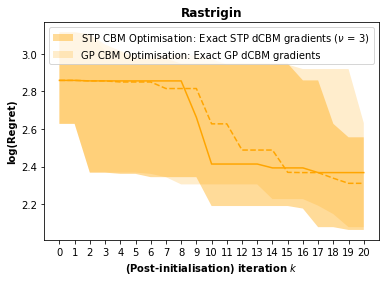

In [98]:
### Visualise!

title = func
plt.figure()

plt.plot(median_stp, color = 'Orange', ls='--')
plt.plot(median_gp, color = 'Orange', ls='-')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_stp, upper_stp, facecolor = 'Orange', alpha=0.4, label='STP CBM Optimisation: Exact STP dCBM gradients ' r'($\nu$' ' = {})'.format(df))
plt.fill_between(xstar, lower_gp, upper_gp, facecolor = 'Orange', alpha=0.2, label='GP CBM Optimisation: Exact GP dCBM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualise!


In [99]:
time_gp, time_stp


(781.8925077915192, 810.536993265152)

In [100]:
### acqFunc attribute x, stddev: run number = 1

acqFuncgp_gp_1 = acqFuncExact(gp_1.history)
acqFuncstp_stp_1 = acqFuncExact(stp_1.history)

e1 = np.std(acqFuncstp_stp_1)
a1 = np.std(acqFuncgp_gp_1)

e1, a1


(0.38212017310647217, 0.3231121964437761)

In [101]:
### acqFunc attribute x, stddev: run number = 2

acqFuncgp_gp_2 = acqFuncExact(gp_2.history)
acqFuncstp_stp_2 = acqFuncExact(stp_2.history)

e2 = np.std(acqFuncstp_stp_2)
a2 = np.std(acqFuncgp_gp_2)

e2, a2


(0.3641154586000418, 0.42518564412262805)

In [102]:
### acqFunc attribute x, stddev: run number = 3

acqFuncgp_gp_3 = acqFuncExact(gp_3.history)
acqFuncstp_stp_3 = acqFuncExact(stp_3.history)

e3 = np.std(acqFuncstp_stp_3)
a3 = np.std(acqFuncgp_gp_3)

e3, a3


(0.3877246330656022, 0.42475545674439924)

In [103]:
### acqFunc attribute x, stddev: run number = 4

acqFuncgp_gp_4 = acqFuncExact(gp_4.history)
acqFuncstp_stp_4 = acqFuncExact(stp_4.history)

e4 = np.std(acqFuncstp_stp_4)
a4 = np.std(acqFuncgp_gp_4)

e4, a4


(0.3699611753033097, 0.47577877347512987)

In [104]:
### acqFunc attribute x, stddev: run number = 5

acqFuncgp_gp_5 = acqFuncExact(gp_5.history)
acqFuncstp_stp_5 = acqFuncExact(stp_5.history)

e5 = np.std(acqFuncstp_stp_5)
a5 = np.std(acqFuncgp_gp_5)

e5, a5


(0.5753325362319289, 0.6252833154737687)

In [105]:
### acqFunc attribute x, stddev: run number = 6

acqFuncgp_gp_6 = acqFuncExact(gp_6.history)
acqFuncstp_stp_6 = acqFuncExact(stp_6.history)

e6 = np.std(acqFuncstp_stp_6)
a6 = np.std(acqFuncgp_gp_6)

e6, a6


(0.4066996452685587, 0.516277105772387)

In [106]:
### acqFunc attribute x, stddev: run number = 7

acqFuncgp_gp_7 = acqFuncExact(gp_7.history)
acqFuncstp_stp_7 = acqFuncExact(stp_7.history)

e7 = np.std(acqFuncstp_stp_7)
a7 = np.std(acqFuncgp_gp_7)

e7, a7


(0.3021183887751589, 0.3414803732012968)

In [107]:
### acqFunc attribute x, stddev: run number = 8

acqFuncgp_gp_8 = acqFuncExact(gp_8.history)
acqFuncstp_stp_8 = acqFuncExact(stp_8.history)

e8 = np.std(acqFuncstp_stp_8)
a8 = np.std(acqFuncgp_gp_8)

e8, a8


(0.3113082063169652, 0.34711763539806795)

In [108]:
### acqFunc attribute x, stddev: run number = 9

acqFuncgp_gp_9 = acqFuncExact(gp_9.history)
acqFuncstp_stp_9 = acqFuncExact(stp_9.history)

e9 = np.std(acqFuncstp_stp_9)
a9 = np.std(acqFuncgp_gp_9)

e9, a9


(0.39937309218698647, 0.4405064106863588)

In [109]:
### acqFunc attribute x, stddev: run number = 10

acqFuncgp_gp_10 = acqFuncExact(gp_10.history)
acqFuncstp_stp_10 = acqFuncExact(stp_10.history)

e10 = np.std(acqFuncstp_stp_10)
a10 = np.std(acqFuncgp_gp_10)

e10, a10


(0.4563367006047843, 0.5557375083175958)

In [110]:
### acqFunc attribute x, stddev: run number = 11

acqFuncgp_gp_11 = acqFuncExact(gp_11.history)
acqFuncstp_stp_11 = acqFuncExact(stp_11.history)

e11 = np.std(acqFuncstp_stp_11)
a11 = np.std(acqFuncgp_gp_11)

e11, a11


(0.29175789896055276, 0.4364907004320317)

In [111]:
### acqFunc attribute x, stddev: run number = 12

acqFuncgp_gp_12 = acqFuncExact(gp_12.history)
acqFuncstp_stp_12 = acqFuncExact(stp_12.history)

e12 = np.std(acqFuncstp_stp_12)
a12 = np.std(acqFuncgp_gp_12)

e12, a12


(0.29545949325112025, 0.3581088100942865)

In [112]:
### acqFunc attribute x, stddev: run number = 13

acqFuncgp_gp_13 = acqFuncExact(gp_13.history)
acqFuncstp_stp_13 = acqFuncExact(stp_13.history)

e13 = np.std(acqFuncstp_stp_13)
a13 = np.std(acqFuncgp_gp_13)

e13, a13


(0.3361586258556505, 0.35905175330117783)

In [113]:
### acqFunc attribute x, stddev: run number = 14

acqFuncgp_gp_14 = acqFuncExact(gp_14.history)
acqFuncstp_stp_14 = acqFuncExact(stp_14.history)

e14 = np.std(acqFuncstp_stp_14)
a14 = np.std(acqFuncgp_gp_14)

e14, a14


(0.42800781854237663, 0.5177756586150365)

In [114]:
### acqFunc attribute x, stddev: run number = 15

acqFuncgp_gp_15 = acqFuncExact(gp_15.history)
acqFuncstp_stp_15 = acqFuncExact(stp_15.history)

e15 = np.std(acqFuncstp_stp_15)
a15 = np.std(acqFuncgp_gp_15)

e15, a15


(0.4794687635048363, 0.41877101077939716)

In [115]:
### acqFunc attribute x, stddev: run number = 16

acqFuncgp_gp_16 = acqFuncExact(gp_16.history)
acqFuncstp_stp_16 = acqFuncExact(stp_16.history)

e16 = np.std(acqFuncstp_stp_16)
a16 = np.std(acqFuncgp_gp_16)

e16, a16


(0.47416719551294906, 0.5147014791567525)

In [116]:
### acqFunc attribute x, stddev: run number = 17

acqFuncgp_gp_17 = acqFuncExact(gp_17.history)
acqFuncstp_stp_17 = acqFuncExact(stp_17.history)

e17 = np.std(acqFuncstp_stp_17)
a17 = np.std(acqFuncgp_gp_17)

e17, a17


(0.4293310864874393, 0.5468092970752805)

In [117]:
### acqFunc attribute x, stddev: run number = 18

acqFuncgp_gp_18 = acqFuncExact(gp_18.history)
acqFuncstp_stp_18 = acqFuncExact(stp_18.history)

e18 = np.std(acqFuncstp_stp_18)
a18 = np.std(acqFuncgp_gp_18)

e18, a18


(0.5038220242119417, 0.5035200978596828)

In [118]:
### acqFunc attribute x, stddev: run number = 19

acqFuncgp_gp_19 = acqFuncExact(gp_19.history)
acqFuncstp_stp_19 = acqFuncExact(stp_19.history)

e19 = np.std(acqFuncstp_stp_19)
a19 = np.std(acqFuncgp_gp_19)

e19, a19


(0.451097731353664, 0.5187058189411909)

In [119]:
### acqFunc attribute x, stddev: run number = 20

acqFuncgp_gp_20 = acqFuncExact(gp_20.history)
acqFuncstp_stp_20 = acqFuncExact(stp_20.history)

e20 = np.std(acqFuncstp_stp_20)
a20 = np.std(acqFuncgp_gp_20)

e20, a20


(0.37737634649822294, 0.380941562274559)

In [120]:
### Summarize arrays: 

stp_stddev = np.sort([e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20])
gp_stddev = np.sort([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20])

np.mean(stp_stddev), np.mean(gp_stddev)


(0.4010868496819281, 0.4515055304082402)

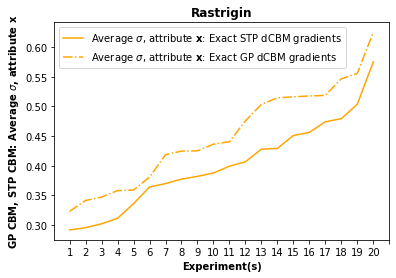

In [121]:
### Visualise!

title = func
plt.figure()

plt.plot(stp_stddev, color = 'Orange', ls='-', label='Average $\sigma$, attribute $\mathbf{x}$: Exact STP dCBM gradients')
plt.plot(gp_stddev, color = 'Orange', ls='-.', label='Average $\sigma$, attribute $\mathbf{x}$: Exact GP dCBM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('Experiment(s)', weight = 'bold')
plt.ylabel('GP CBM, STP CBM: Average $\sigma$, attribute $\mathbf{x}$', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show() #visualise!
